## Results of point pollution dilbit spill scenarios at Turn Point
Plotting functions for comparing survival and recovery of groups of species within a single model scenario from the Salish Sea Atlantis Model

In [1]:
import sys
import os
import xarray as xr
import numpy as np
import pandas as pd
from pathlib import Path
import geopandas as gpd
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
sys.path.append('/ocean/rlovindeer/MOAD/analysis-raisha/notebooks/')
import ssam_groups as groups
import ssam_plot as splot

### Define scenario and control files

In [6]:
this_run = 'v6699_Scenario_5b_2019-07-03_*'

In [7]:
# Read in salish sea atlantis output files.
scenario_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/')
scenario_paths = sorted([p for p in scenario_root.glob(this_run + '/outputSalishSea.nc')])
scenario_datasets = [xr.open_dataset(scen,decode_cf=True) for scen in scenario_paths]

In [8]:
control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/v6699_Scenario_5b_2019-07-03_1000/outputSalishSea.nc"
control = xr.open_dataset(str(control_file), decode_cf=True)
time = np.ma.filled(control.variables['t'], np.nan)

In [9]:
scenario_paths

[PosixPath('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/v6699_Scenario_5b_2019-07-03_1000/outputSalishSea.nc'),
 PosixPath('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/v6699_Scenario_5b_2019-07-03_1000_uptakeoff/outputSalishSea.nc'),
 PosixPath('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/v6699_Scenario_5b_2019-07-03_5000/outputSalishSea.nc'),
 PosixPath('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/v6699_Scenario_5b_2019-07-03_5000_uptakeoff/outputSalishSea.nc')]

In [10]:
# time after burn-in
start = 20
end = time.size-1

In [13]:
def plot_pah(pah):
    fig, ax = plt.subplots(figsize = (14,3))
    names = []

    for scenario, path in zip(scenario_datasets,scenario_paths):
        
        names.append(path.parent.stem)
        contam = np.ma.filled(scenario.variables[str(pah)][start:end,:,:], np.nan)
        volume = np.ma.filled(scenario.variables['volume'][start:end,:,:], np.nan)
        contam_mass_tbl = contam * volume
        contam_mass_tb = contam_mass_tbl.sum(axis=2)
        contam_mass_t = contam_mass_tb.sum(axis=1)
        ax.plot(time[start:end], contam_mass_t) 

    ax.set_title('Mass of '+ pah +' in water column', fontsize = 12)
    ax.set_ylabel('mg PAH')
    ax.legend(names, loc='best');

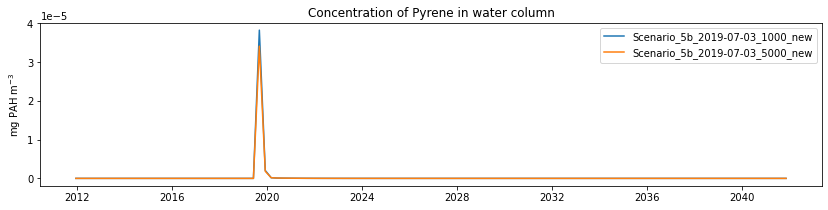

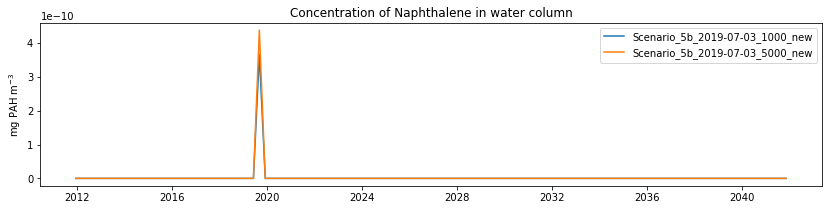

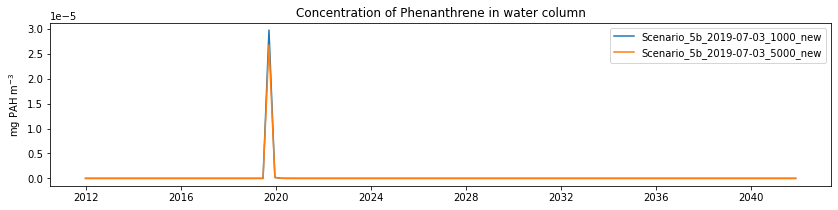

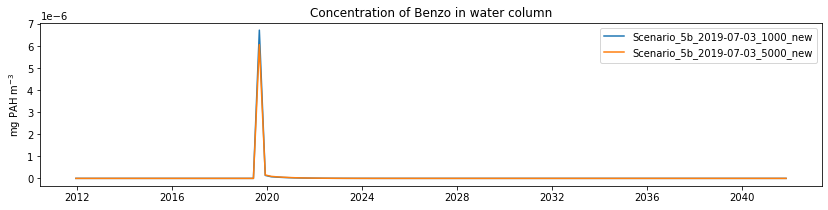

In [80]:
for pah in groups.pahs:
    plot_pah(pah)

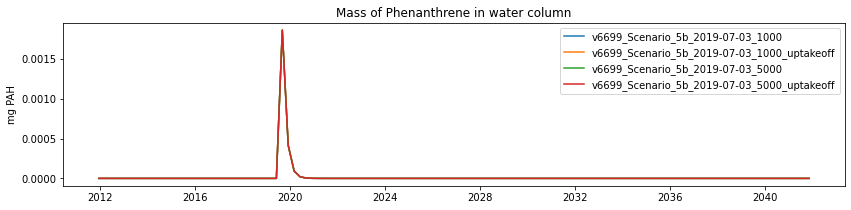

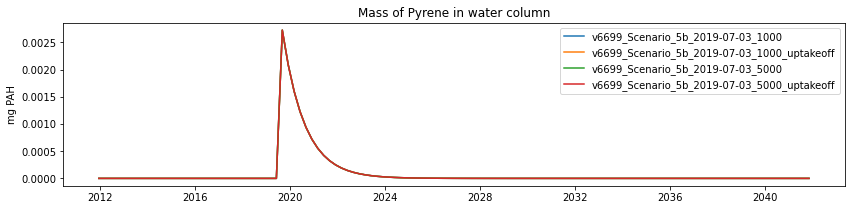

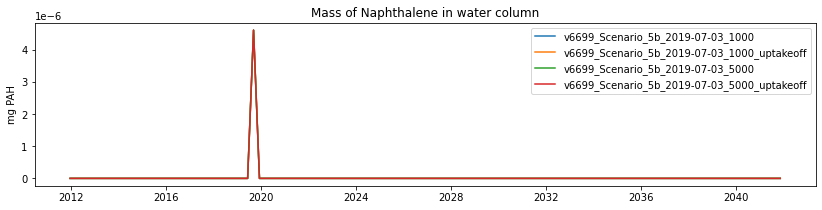

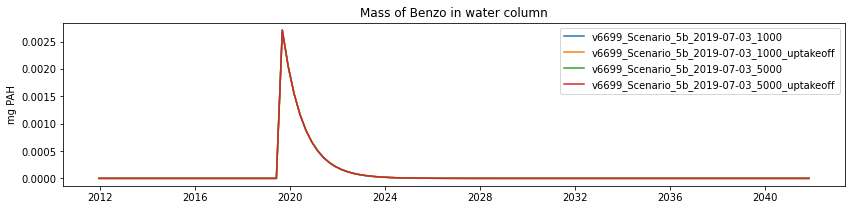

In [14]:
for pah in groups.pahs:
    plot_pah(pah)

#### Concentration of PAH inside cell tissue

In [81]:
def tissue_concentration(group, pah, scenario_datasets, scenario_paths):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

    names = []

    for species in group:
        
        bio_index = (list(group).index(species))

        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3

        ax = fig.add_subplot(gs[position])

        for scenario, path in zip(scenario_datasets,scenario_paths):

            names.append(path.parent.stem)

            pelagic_oiled = np.ma.filled(scenario.variables[group[species] + '_' + pah][start:end,:,0:6], np.nan) # tonnes
            pelagic_oiled = pelagic_oiled.sum(axis=2) 
            pelagic_oiled = pelagic_oiled.sum(axis=1) 
            ax.plot(time[start:end], pelagic_oiled, linewidth = 2) #semilogy color = line_colour, linestyle = line_type, 
        
        plt.ylabel('mg PAH', fontsize=12)
        ax.set_title(species)
    ax.legend(names, bbox_to_anchor=(1.05, 1), fontsize=12);
    fig.suptitle(str(pah))

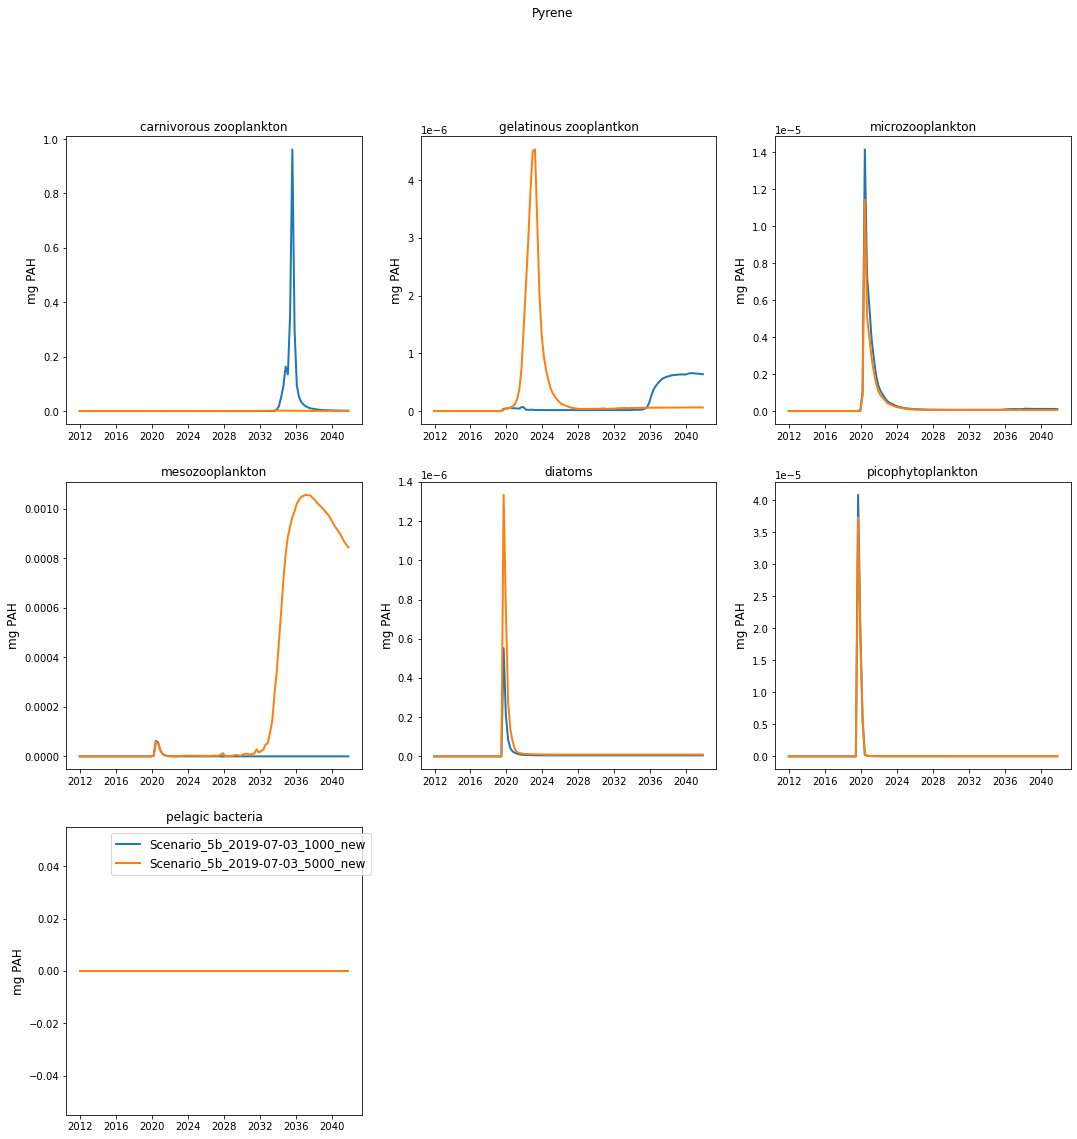

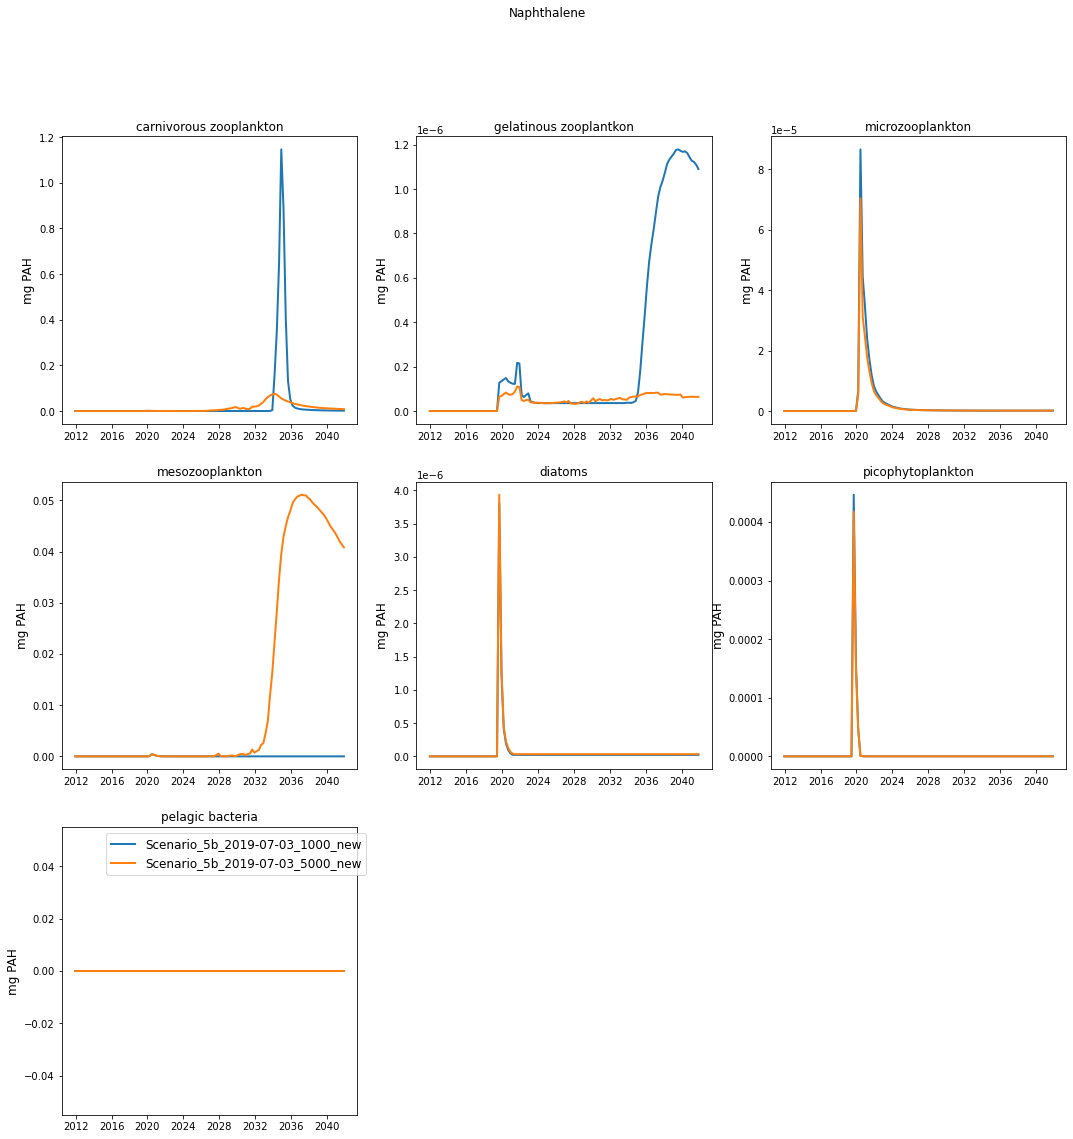

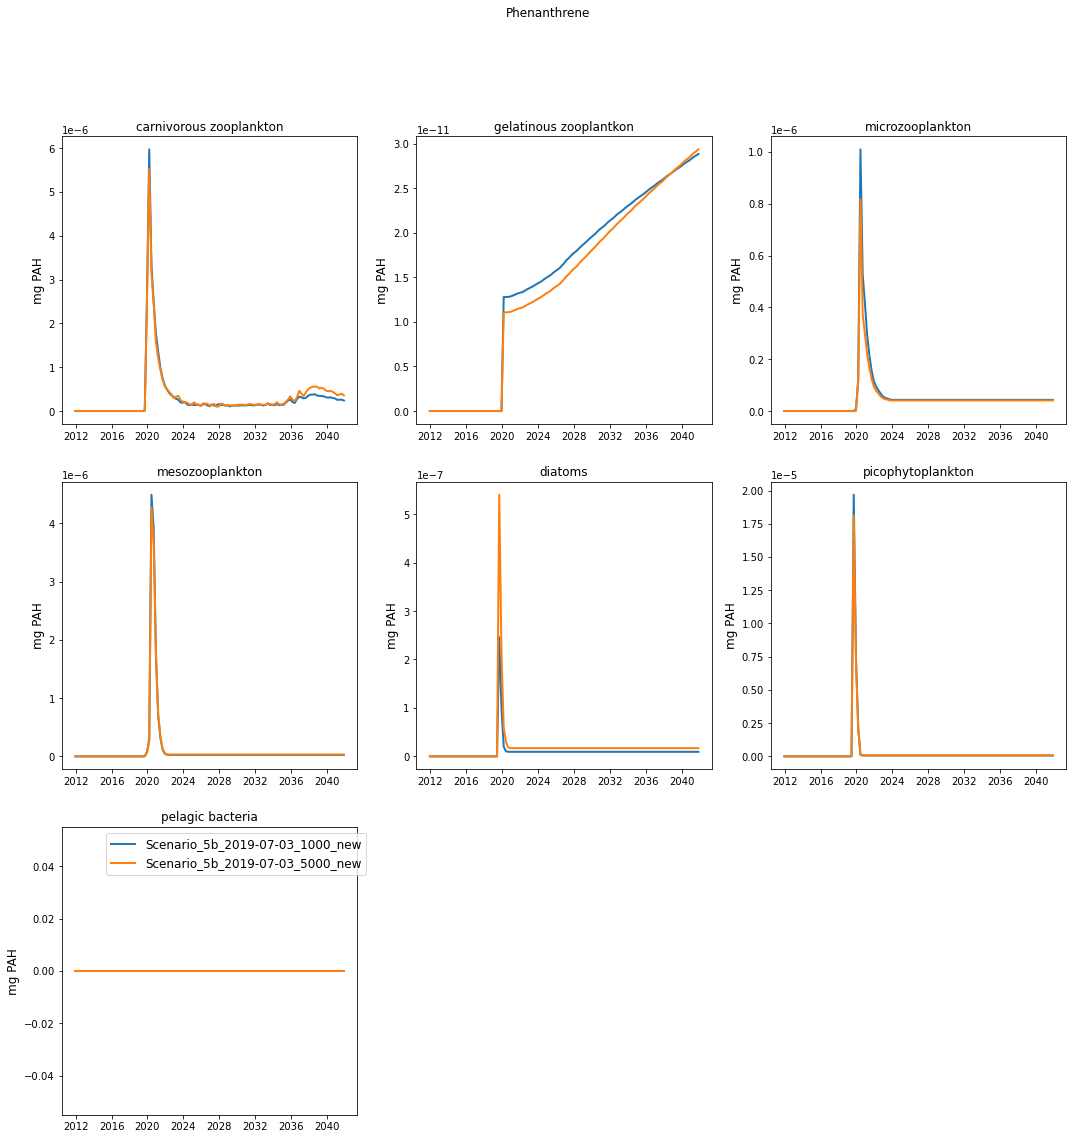

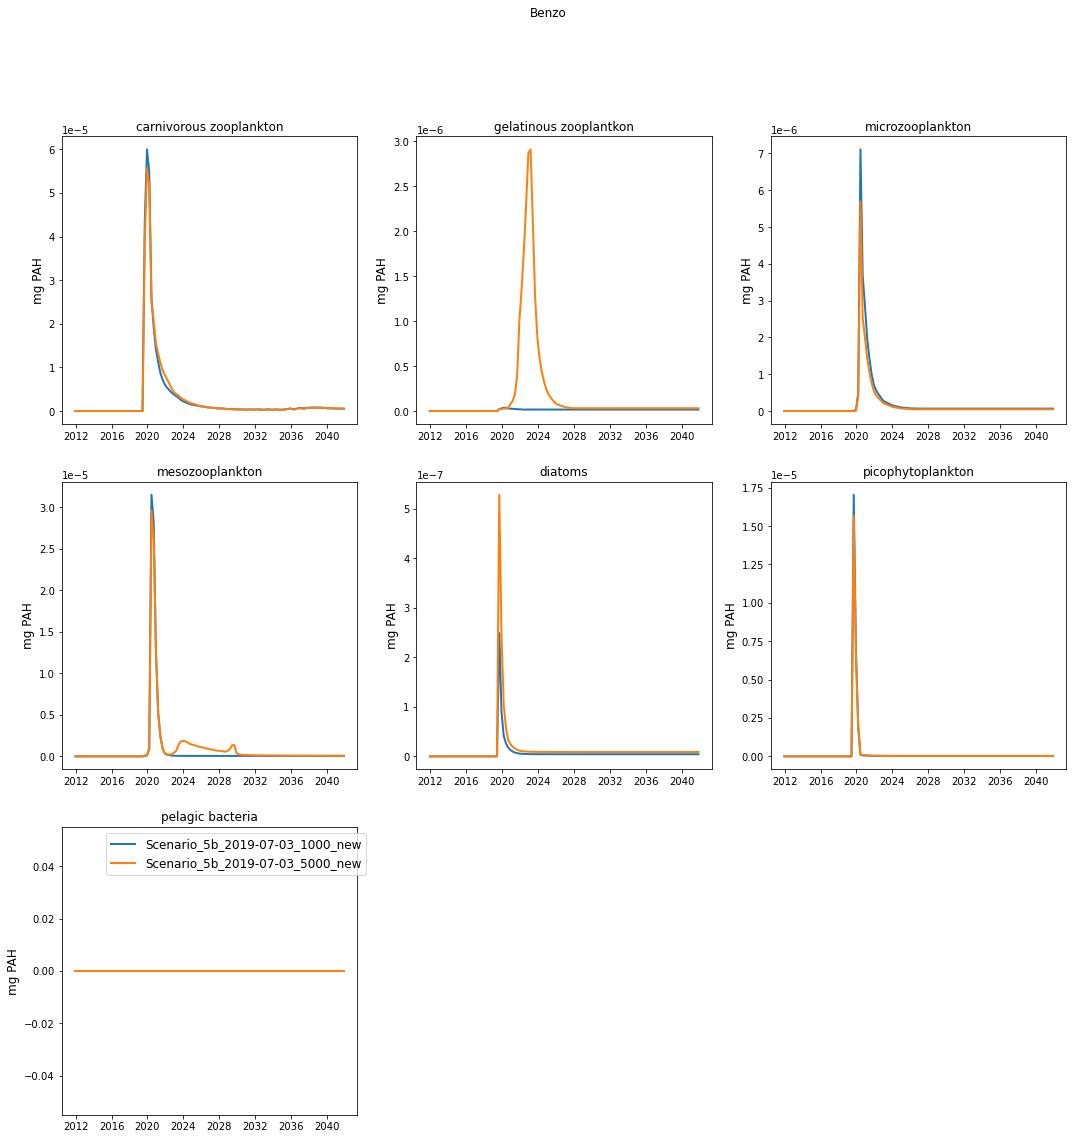

In [82]:
for pah in groups.pahs:
    tissue_concentration(groups.plankton,pah,scenario_datasets,scenario_paths)

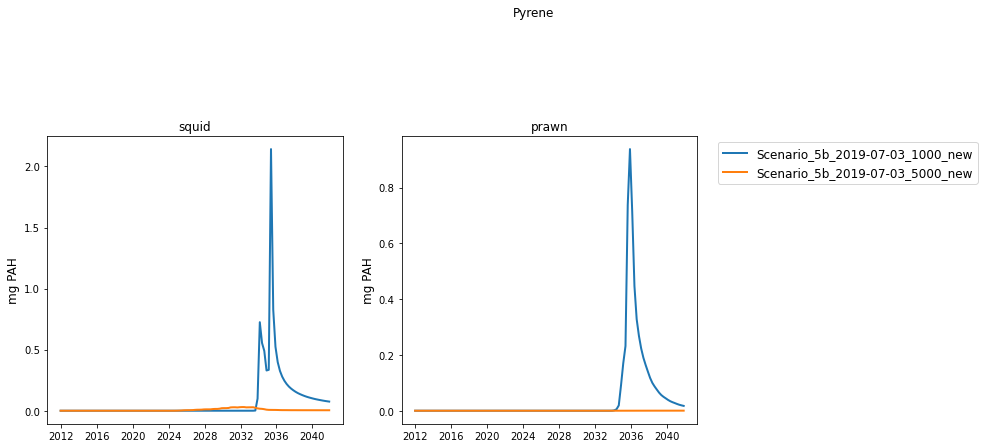

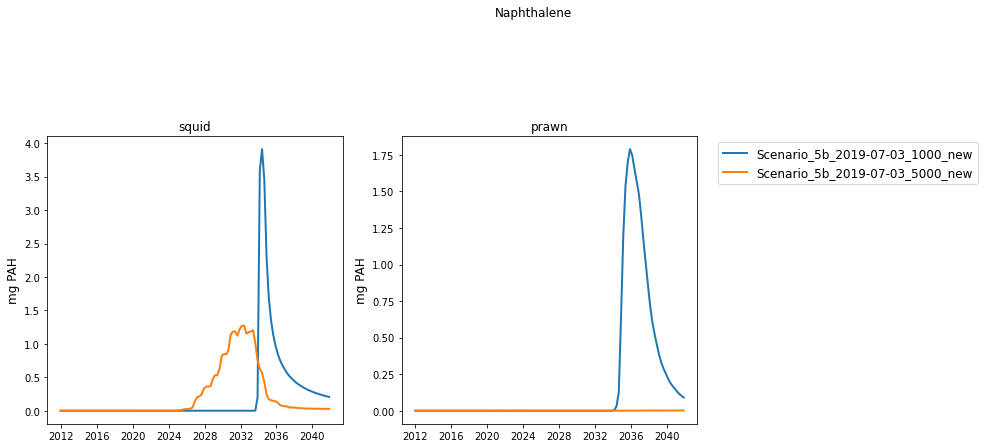

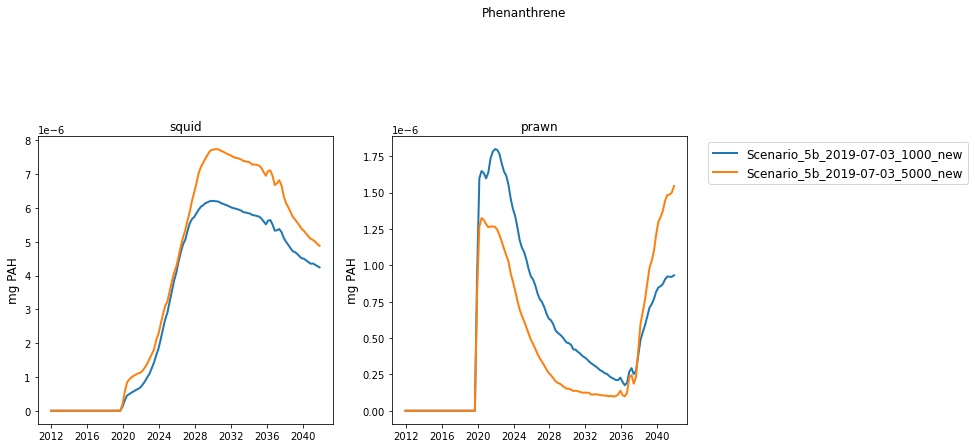

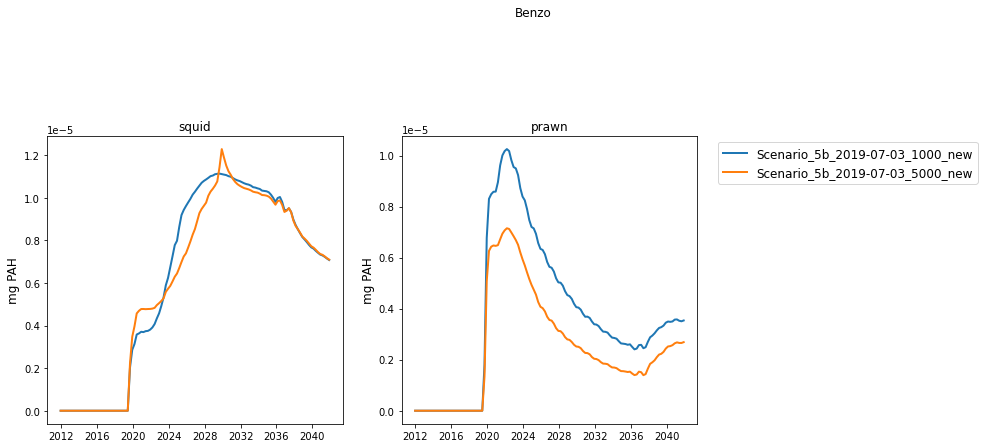

In [83]:
for pah in groups.pahs:
    tissue_concentration(groups.pelagic_invertebrates,pah,scenario_datasets,scenario_paths)

In [84]:
def tissue_vertebrate_concentration(group, pah, age):

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

    names = []

    for species in group:
        
        bio_index = (list(group).index(species))

        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3

        ax = fig.add_subplot(gs[position])

        for scenario, path in zip(scenario_datasets,scenario_paths):

            names.append(path.parent.stem)
            scenario = xr.open_dataset(str(path), decode_cf=True)
            pelagic_oiled = np.ma.filled(scenario.variables[group[species] + str(age) + '_' + pah][start:end,:,0:6], np.nan)
            pelagic_oiled = pelagic_oiled.sum(axis=2) 
            pelagic_oiled = pelagic_oiled.sum(axis=1) 
            ax.plot(time[start:end], pelagic_oiled, linewidth = 2) 
        
        plt.ylabel('mg PAH', fontsize=12)
        ax.set_title(species)
    ax.legend(names, bbox_to_anchor=(1.05, 1), fontsize=12);
    fig.suptitle(str(pah));

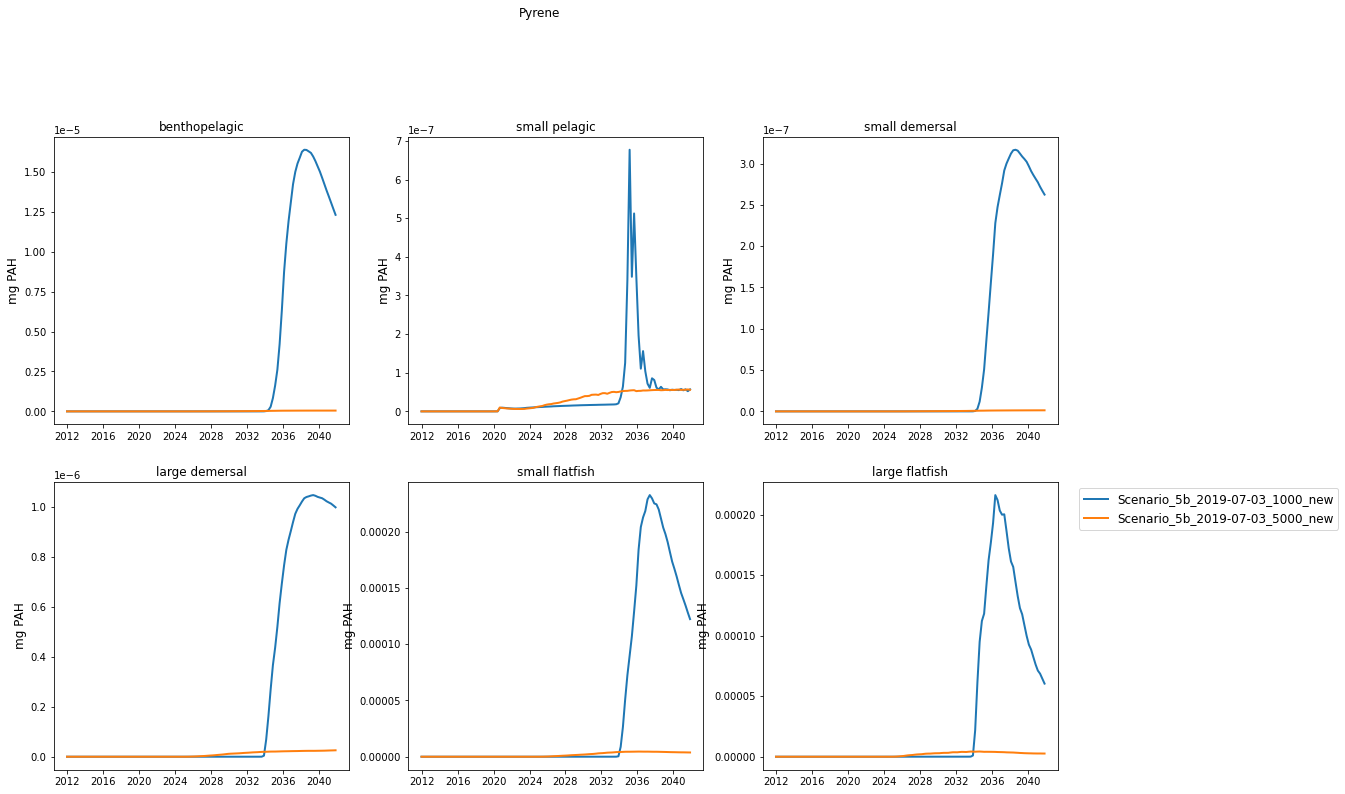

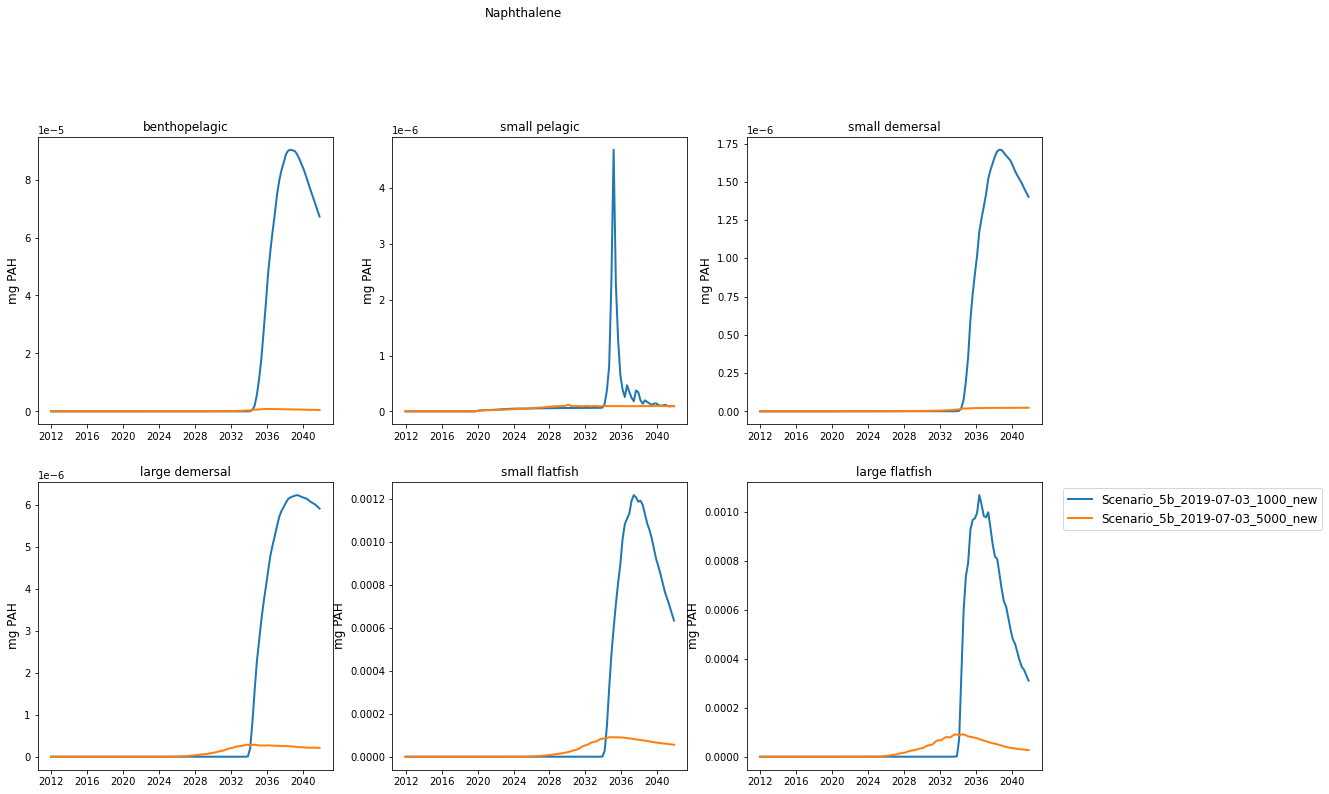

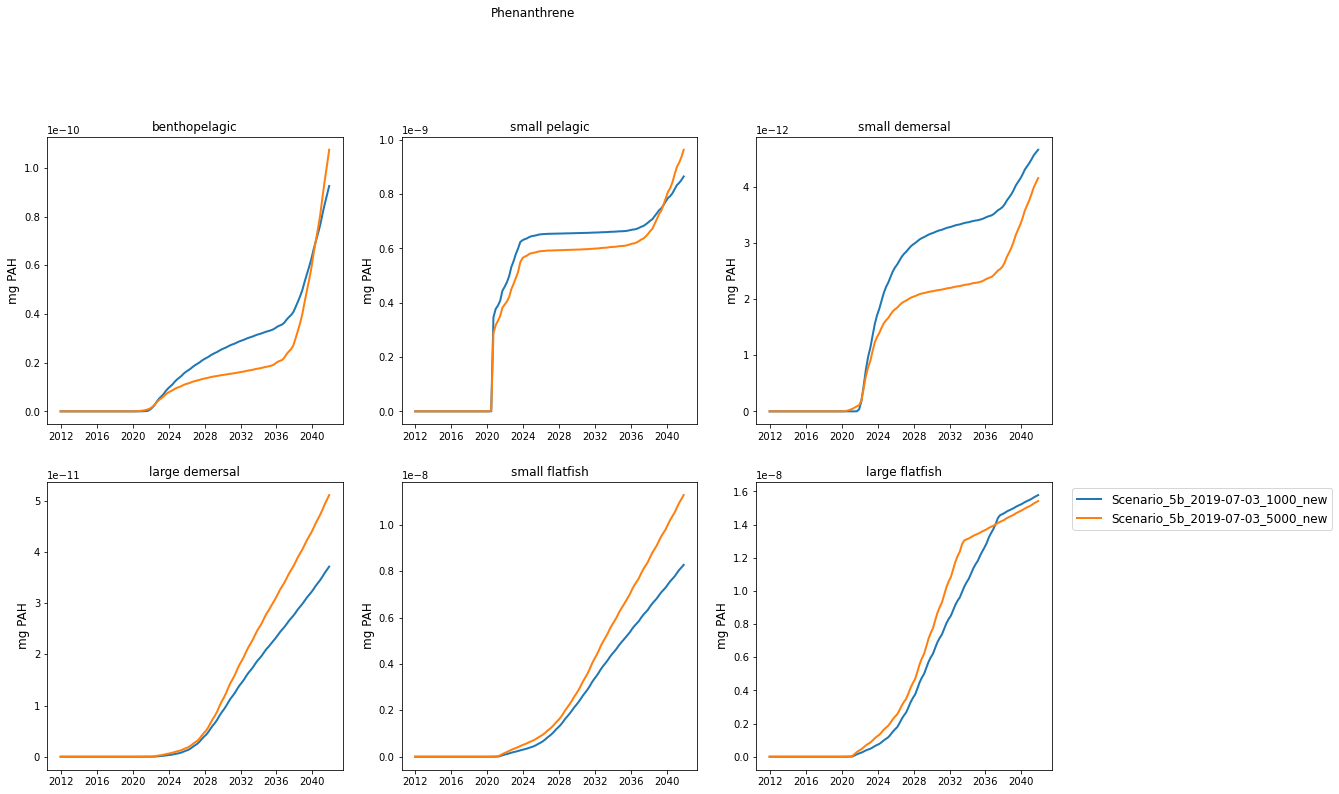

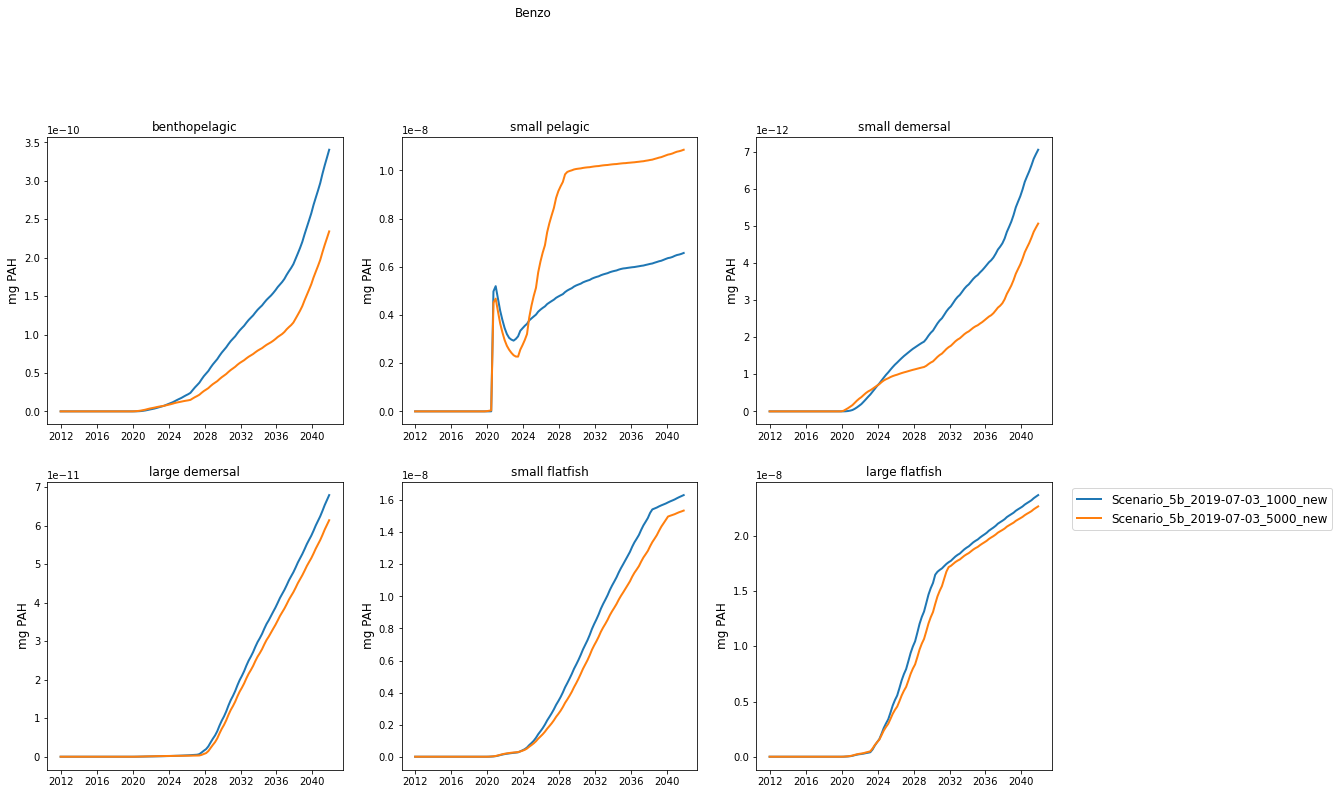

In [85]:
for pah in groups.pahs:
    tissue_vertebrate_concentration(groups.other_fish,pah, 1)

#### Change in biomass relative to a control

In [86]:
def pelagic_compare_scenarios(group, y_min=None, y_max=None): #bacteria, plankton, sharks, birds, mammals, named_fish, salmon, fish, benth_feeders

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

    for species in group:
        
        names = ['control']

        bio_index = (list(group).index(species))

        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3

        ax = fig.add_subplot(gs[position])

        pelagic_control = np.ma.filled(control.variables[group[species] + '_N'][start:end,:,0:6], np.nan)
        pelagic_control = pelagic_control.sum(axis=2)
        pelagic_control = pelagic_control.sum(axis=1)
        control_ratio = (pelagic_control / pelagic_control-1)*100
        ax.plot(time[start:end], control_ratio, 'k', linewidth = 2)

        for scenario, path in zip(scenario_datasets,scenario_paths):

            names.append(path.parent.stem)
            pelagic_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][start:end,:,0:6], np.nan) # tonnes
            pelagic_oiled = pelagic_oiled.sum(axis=2) 
            pelagic_oiled = pelagic_oiled.sum(axis=1) 
            ratio = (pelagic_oiled / pelagic_control-1)*100
            ax.plot(time[start:end], ratio, linewidth = 2) #semilogy color = line_colour, linestyle = line_type, 

        plt.ylabel('Percent (%) change', fontsize=12)
        ax.set_title(species)
        ax.set_ylim([y_min, y_max])
    fig.legend(names, bbox_to_anchor=(1.05, 1), fontsize=12); #loc='upper left', 

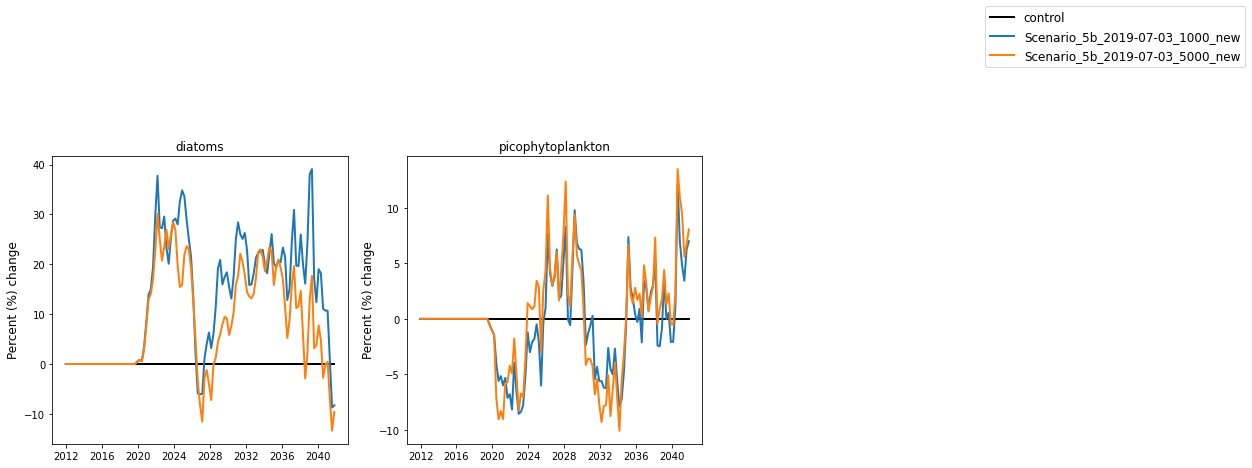

In [87]:
pelagic_compare_scenarios(groups.phytoplankton)

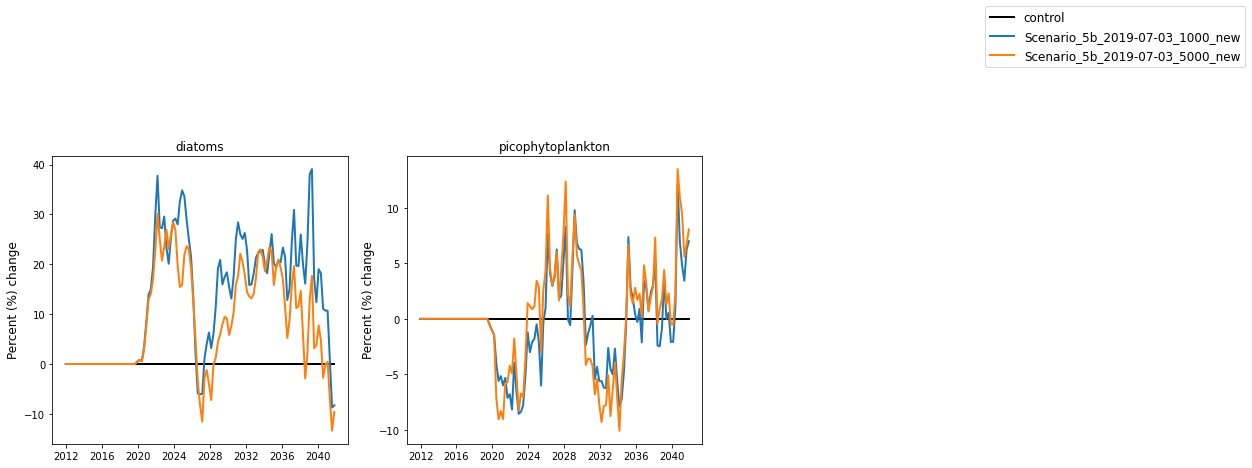

In [88]:
pelagic_compare_scenarios(groups.phytoplankton)

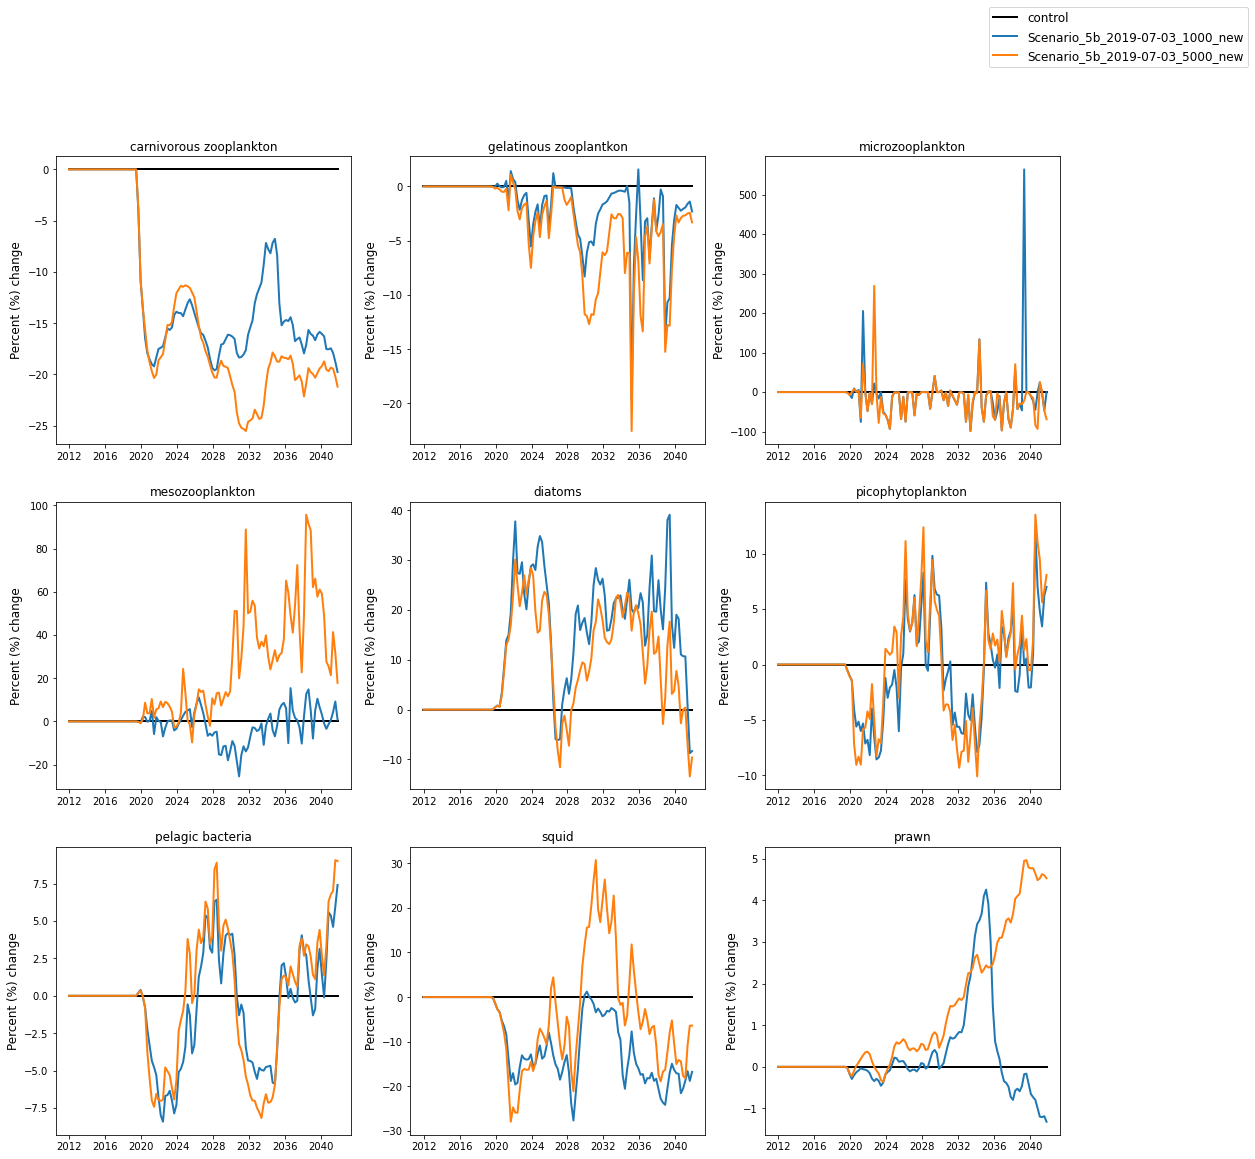

In [89]:
pelagic_compare_scenarios(groups.planktonic) # Haro Boundary

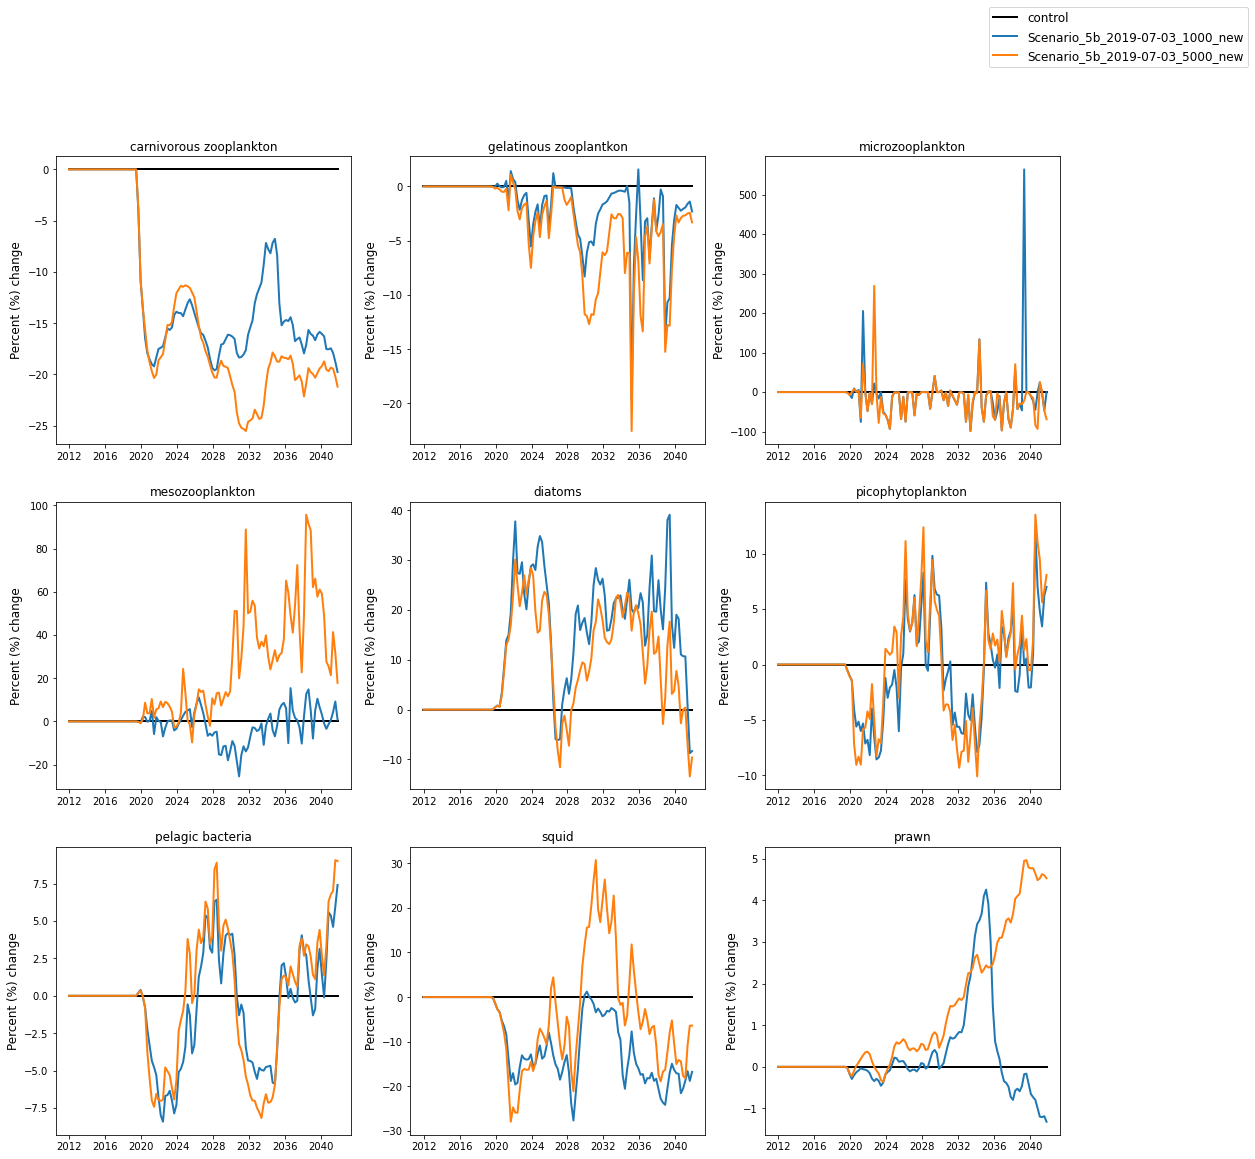

In [90]:
pelagic_compare_scenarios(groups.planktonic) # Haro Boundary

In [91]:
def plot_pelagic_depth(group):

    fig = plt.figure(figsize=(18, 27), facecolor='white')
    gs = plt.GridSpec(3, 4, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1, 1], height_ratios=[1, 1, 1]) 

    depth = [100, 50, 25, 0]

    for species in group:

        names = []

        bio_index = (list(group).index(species))

        if bio_index < 4:
            position = 0, bio_index
        elif bio_index > 8: 
            position = 2, bio_index-8
        else :
            position = 1, bio_index-4

        ax = fig.add_subplot(gs[position])
        pelagic_control = np.ma.filled(control.variables[group[species] + '_N'][start:end,:,2:6], np.nan)
        p_control = pelagic_control.sum(axis=0)
        p_control = p_control.sum(axis=0)
    
        ax.set_ylim(100, 0)  # decreasing depth
        for scenario, path in zip(scenario_datasets,scenario_paths):

            names.append(path.parent.stem)
            pelagic_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][start:end,:,2:6], np.nan) # tonnes, take only water column layers
            p_oiled = pelagic_oiled.sum(axis=0)
            p_oiled = p_oiled.sum(axis=0)
            ax.plot(p_oiled, depth, linewidth = 2) #color=line_colour, linestyle=line_type,
        ax.plot(p_control, depth, '-.k', linewidth = 2)
        ax.set_title(species)
        ax.set_ylabel('depth, m')
        ax.set_xlabel('mg N$^{-3}$')
    names.append('control')
    ax.legend(names, bbox_to_anchor=(1.05, 1), fontsize=12); #loc='upper left', )

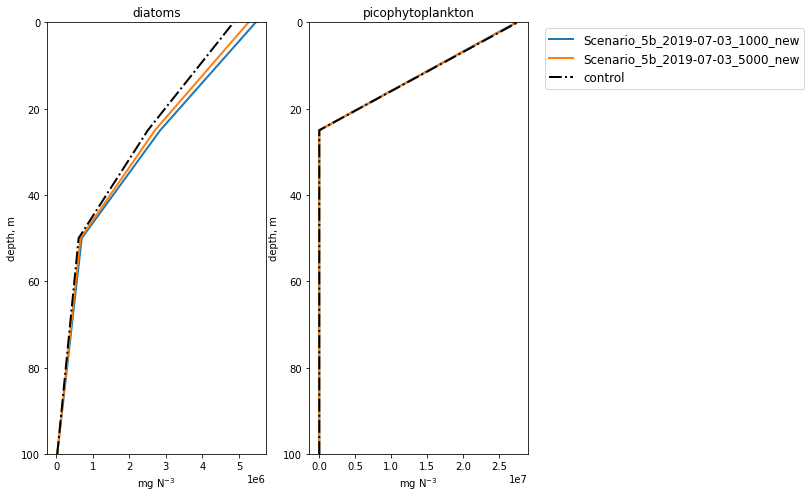

In [92]:
plot_pelagic_depth(groups.phytoplankton) 

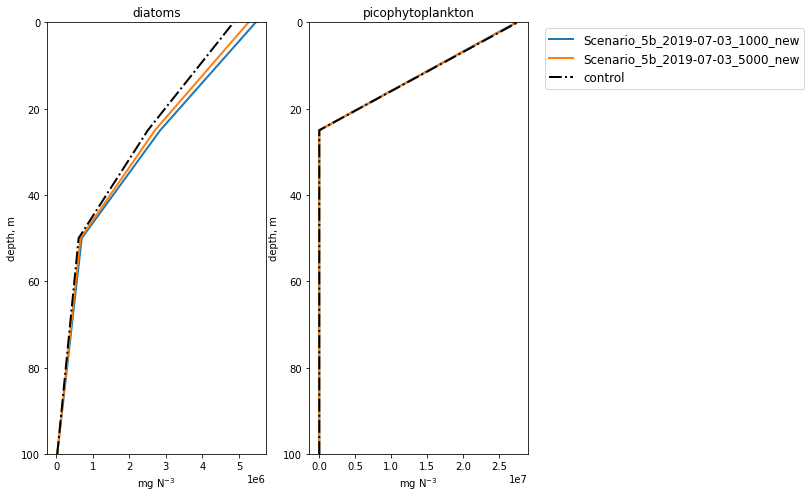

In [93]:
plot_pelagic_depth(groups.phytoplankton)

In [94]:
def pelagic_compare_scenarios(group, y_min=None, y_max=None): #bacteria, plankton, sharks, birds, mammals, named_fish, salmon, fish, benth_feeders

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

    names = ['control']

    for species in group:
        
        bio_index = (list(group).index(species))

        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3

        ax = fig.add_subplot(gs[position])

        pelagic_control = np.ma.filled(control.variables[group[species] + '_N'][start:end,:,0:6], np.nan)
        pelagic_control = pelagic_control.sum(axis=2)
        pelagic_control = pelagic_control.sum(axis=1)
        control_ratio = (pelagic_control / pelagic_control-1)*100
        ax.plot(time[start:end], control_ratio, 'k', linewidth = 2)
    
        for scenario, path in zip(scenario_datasets,scenario_paths):

            names.append(path.parent.stem)
            pelagic_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][start:end,:,0:6], np.nan) # tonnes
            pelagic_oiled = pelagic_oiled.sum(axis=2) 
            pelagic_oiled = pelagic_oiled.sum(axis=1) 
            ratio = (pelagic_oiled / pelagic_control-1)*100
            ax.plot(time[start:end], ratio, linewidth = 2)
       
        plt.ylabel('Percent (%) change', fontsize=12)
        ax.set_title(species)
        ax.set_ylim([y_min, y_max])
    ax.legend(names, bbox_to_anchor=(1.05, 1), fontsize=12); #loc='upper left', )


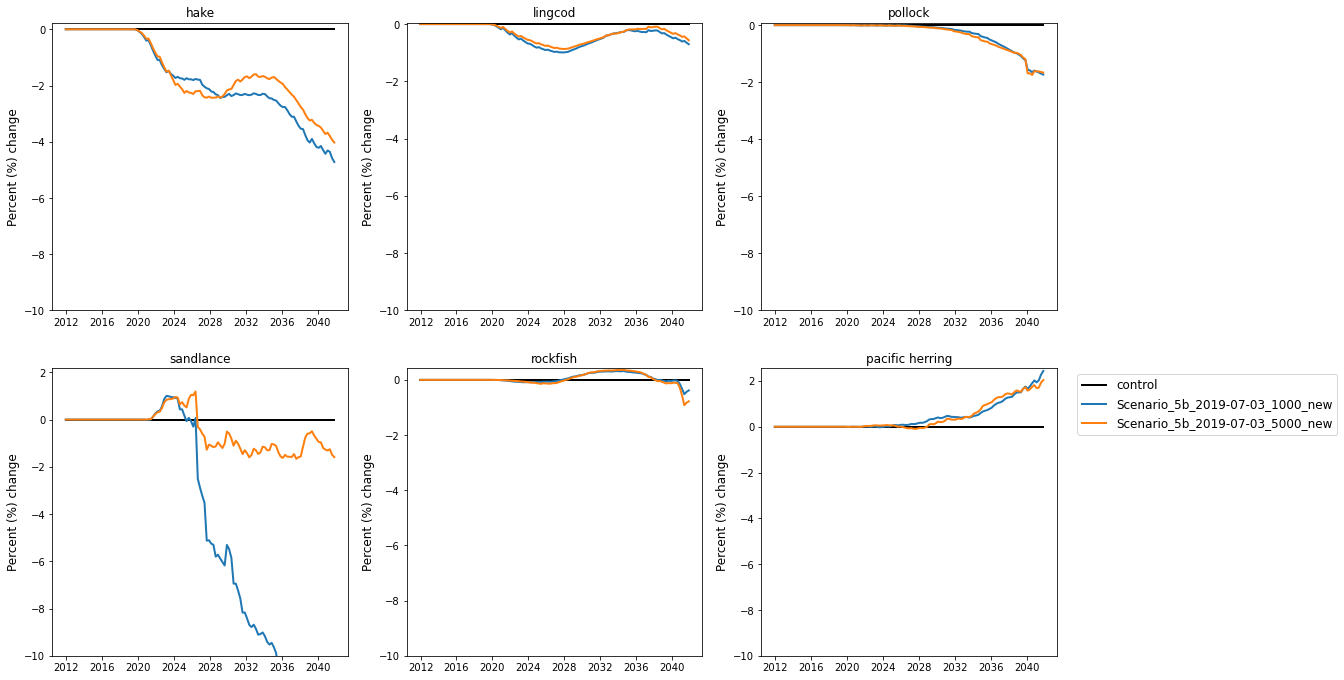

In [95]:
pelagic_compare_scenarios(groups.named_fish, y_min=-10, y_max=None)

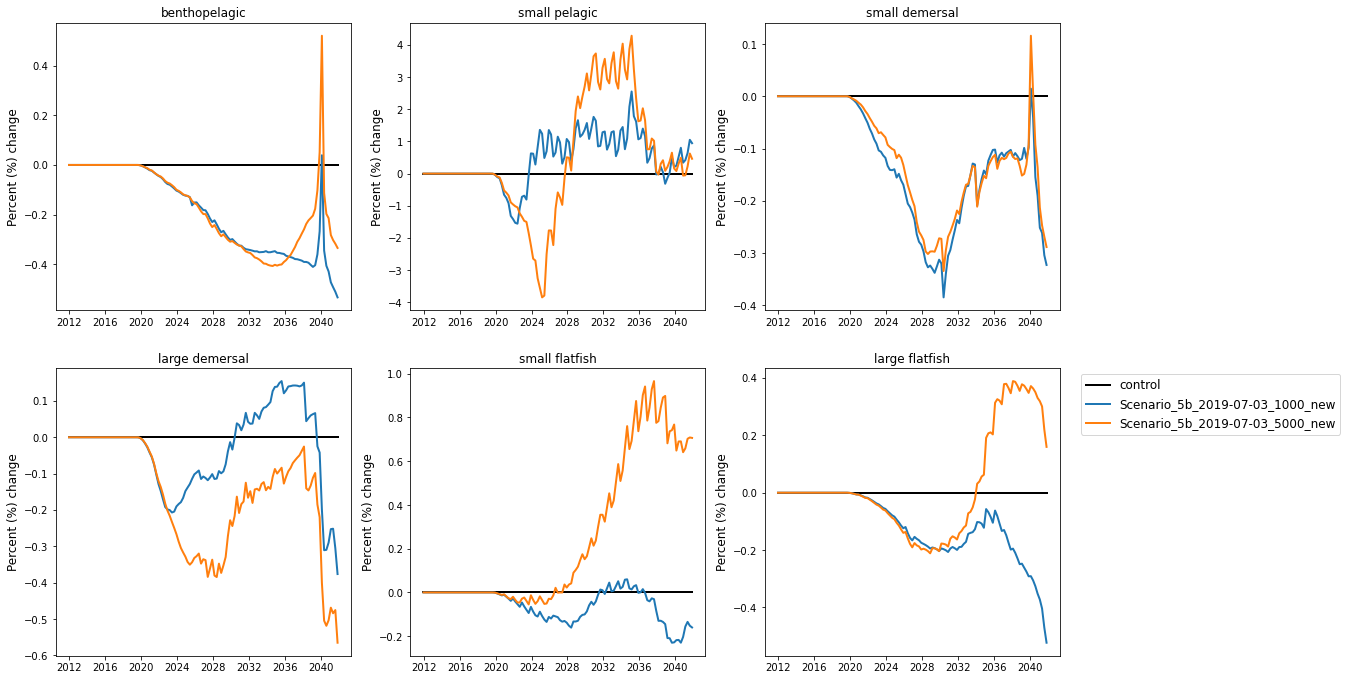

In [129]:
pelagic_compare_scenarios(groups.other_fish, y_min=None, y_max=None)

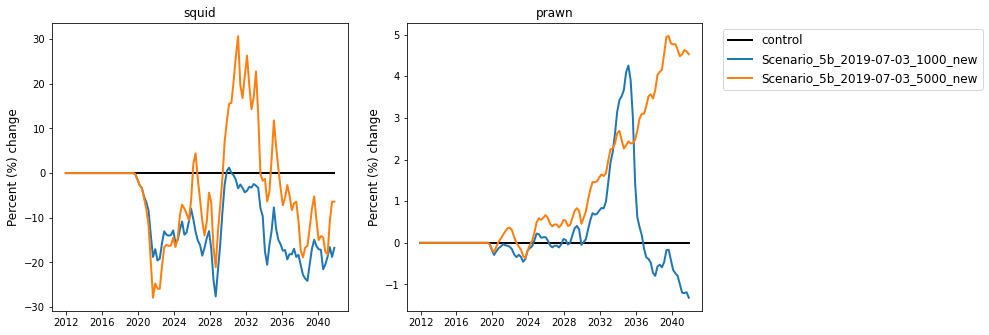

In [97]:
pelagic_compare_scenarios(groups.pelagic_invertebrates, y_min=None, y_max=None)

In [98]:
def benthic_compare_scenarios(group, time=time, start=start, end=end, y_min=None, y_max=None): #bacteria, plankton, sharks, birds, mammals, named_fish, salmon, fish, benth_feeders

    fig = plt.figure(figsize=(18, 18), facecolor='white')
    gs = plt.GridSpec(3, 3, wspace=0.2, hspace=0.2, width_ratios=[1, 1, 1], height_ratios=[1, 1, 1])

    names = ['control']

    for species in group:
        
        bio_index = (list(group).index(species))

        if bio_index < 3:
            position = 0, bio_index
        elif bio_index > 5: 
            position = 2, bio_index-6
        else :
            position = 1, bio_index-3

        ax = fig.add_subplot(gs[position])

        pelagic_control = np.ma.filled(control.variables[group[species] + '_N'][start:end,:], np.nan)
        pelagic_control = pelagic_control.sum(axis=1)
        control_ratio = (pelagic_control / pelagic_control-1)*100
        ax.plot(time[start:end], control_ratio, 'k', linewidth = 2)
    
        for scenario, path in zip(scenario_datasets,scenario_paths):

            names.append(path.parent.stem)
            pelagic_oiled = np.ma.filled(scenario.variables[group[species] + '_N'][start:end,:], np.nan) # tonnes
            pelagic_oiled = pelagic_oiled.sum(axis=1) 
            ratio = (pelagic_oiled / pelagic_control-1)*100
            ax.plot(time[start:end], ratio, linewidth = 2)
       
        plt.ylabel('Percent (%) change', fontsize=12)
        ax.set_title(species)
        ax.set_ylim([y_min, y_max])
    ax.legend(names, bbox_to_anchor=(1.05, 1), fontsize=12); #loc='upper left', )

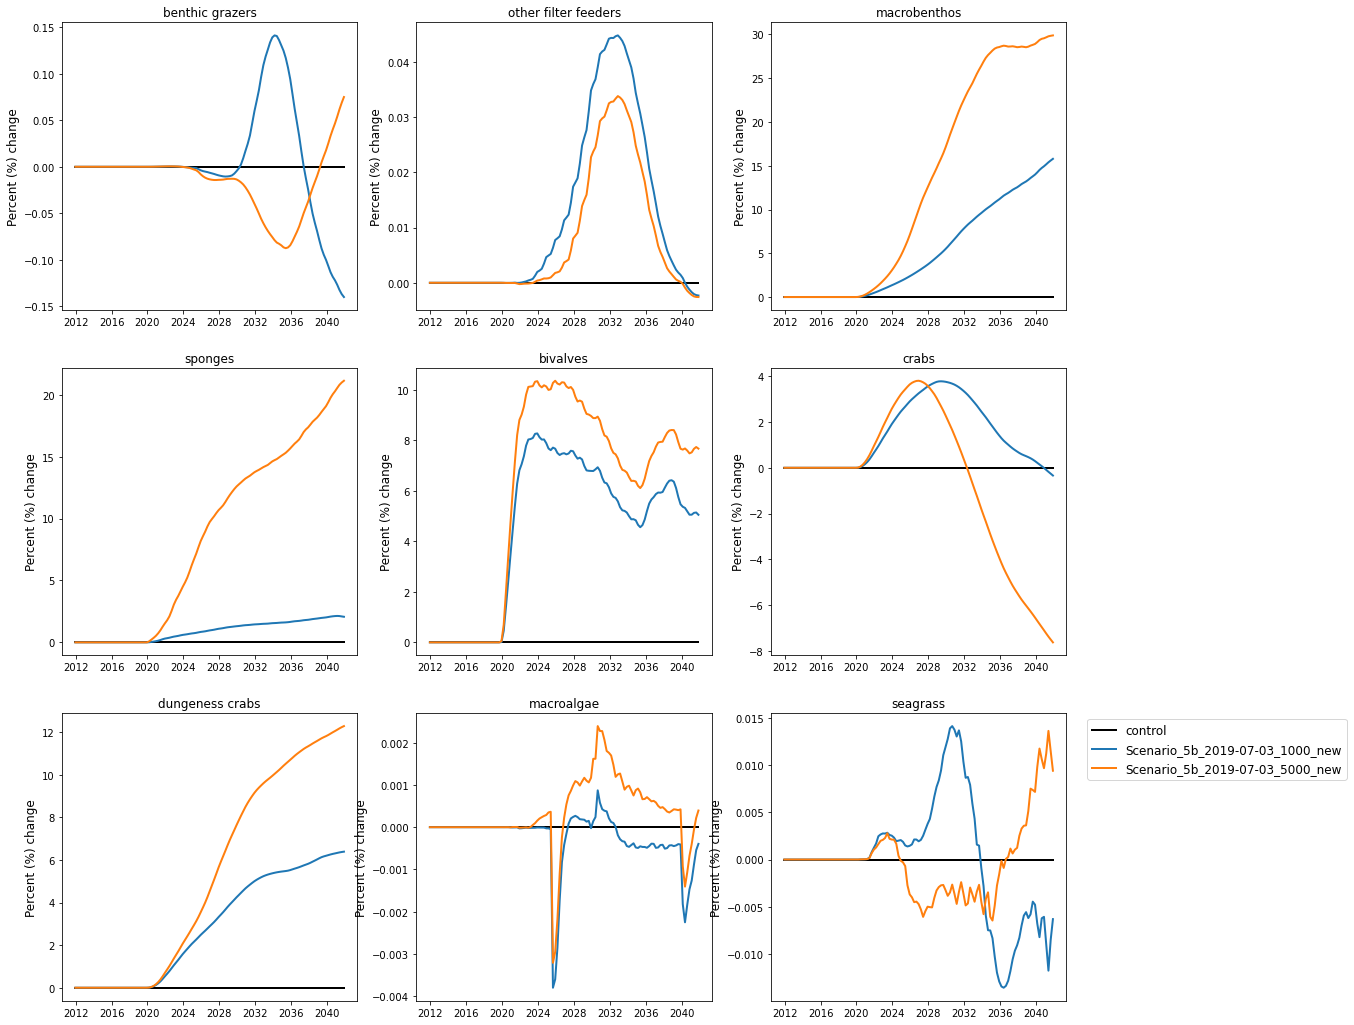

In [99]:
benthic_compare_scenarios(groups.benthos, y_min=None, y_max=None)

### Map display

In [100]:
def map_aggregate_time(variable_name, v_max=None, v_min=None):

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
    map_df = gpd.read_file(shapefile_name)
    map_df = map_df.sort_values(by=['BOX_ID'])
    box_depth = map_df['BOTZ']
    land_boxes = box_depth==0
    land_boxes = map_df.index[land_boxes]
    land_df = map_df.loc[land_boxes]

    _cmap = cm.Purples
    
    # map of single variable ratio across the whole simulation

    # Pull variables for all scenarios
    fig = plt.figure(figsize=(29, 8), facecolor='white') #figsize=(9, 12)
    gs = plt.GridSpec(1, len(scenario_paths), wspace=0.5, hspace=0.2, height_ratios=[1],)

    position = 0

    for scenario, path in zip(scenario_datasets,scenario_paths):

        dVar_s = scenario.variables[variable_name]
        dVar_s = dVar_s.mean(axis=2)
        pah = dVar_s.mean(axis=0)

        # Add scenario data to Atlantis spatial data
        map_df['pah'] = pah
        map_df.loc[land_boxes, 'pah'] = 0

        ax = fig.add_subplot(gs[0, position])
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=-0.5) 
        ax = map_df.plot(column = 'pah', cmap=_cmap, ax=ax, vmin=v_min, vmax=v_max, cax=cax,
            legend=True, #legend_kwds={'label': variable_name + ' % difference from control'},
            )
        ax.set_title(path.parent.stem, fontsize = 12)
        map_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
        land_df.plot(ax=ax, color='white');
        position = position+1

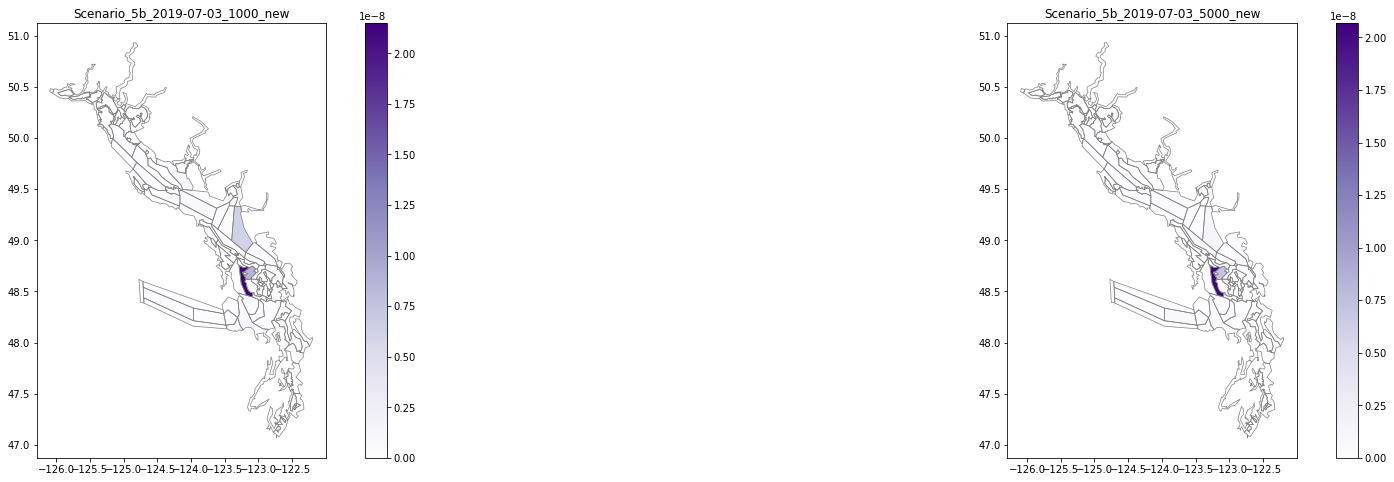

In [101]:
map_aggregate_time('Pyrene',v_max=None, v_min=None)

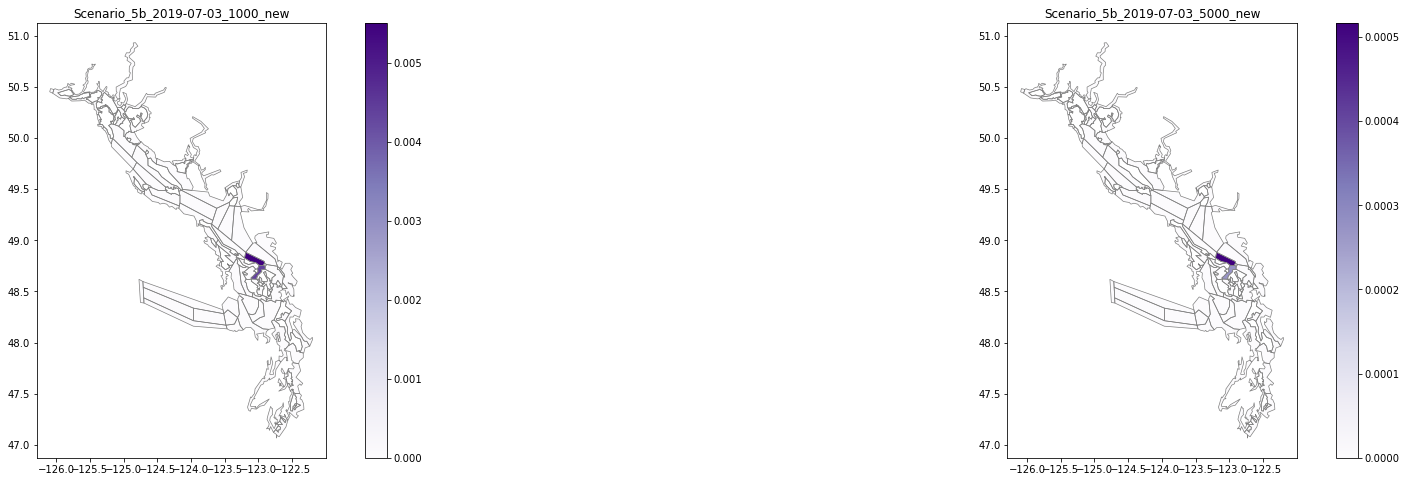

In [102]:
map_aggregate_time('Squid_Pyrene', v_max=None, v_min=None)

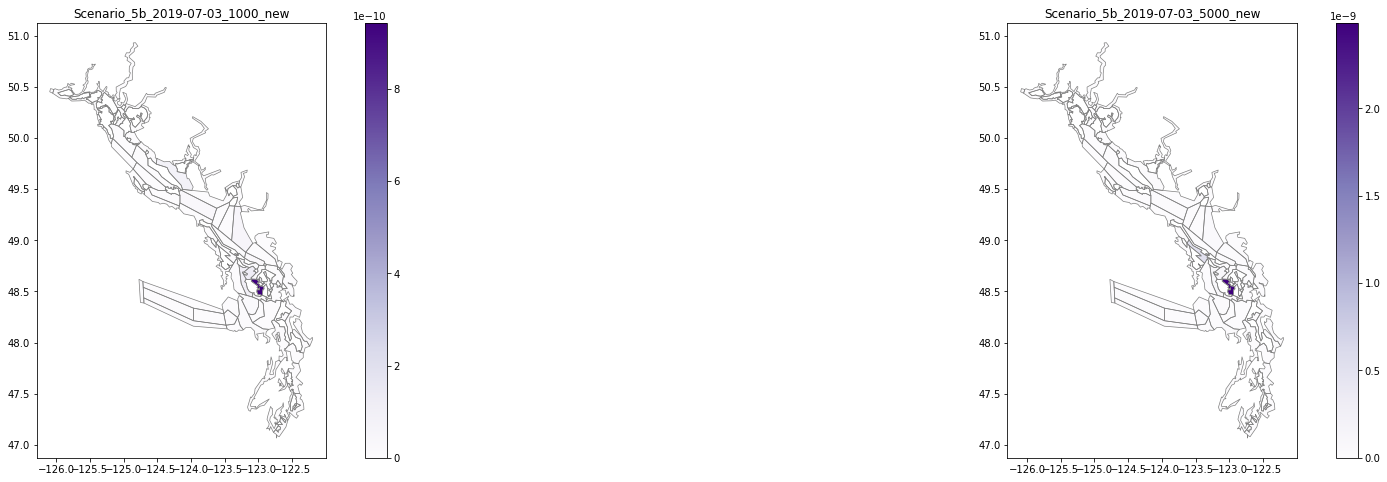

In [103]:
map_aggregate_time('Diatom_Pyrene',v_max=None, v_min=None)

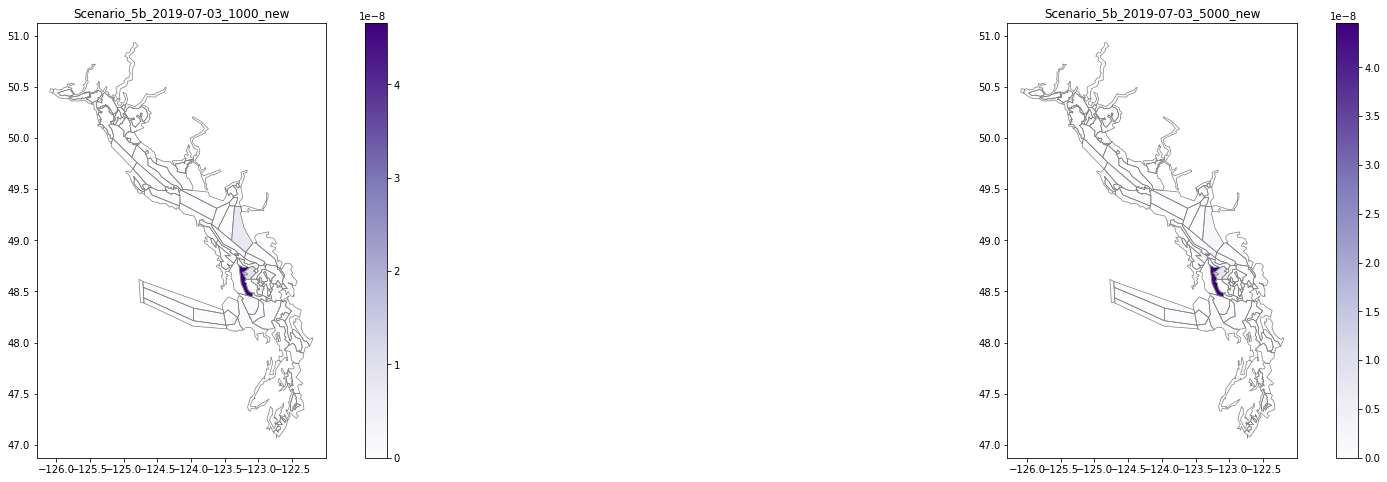

In [104]:
map_aggregate_time('PicoPhytopl_Pyrene',v_max=None, v_min=None)

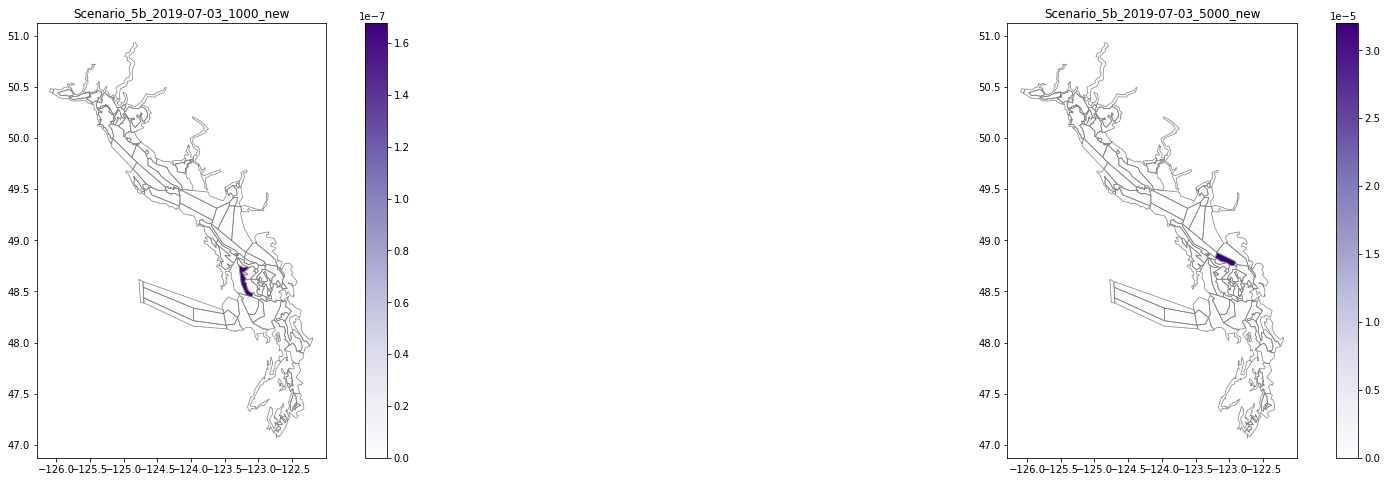

In [105]:
map_aggregate_time('Zoo_Pyrene', v_max=None, v_min=None)

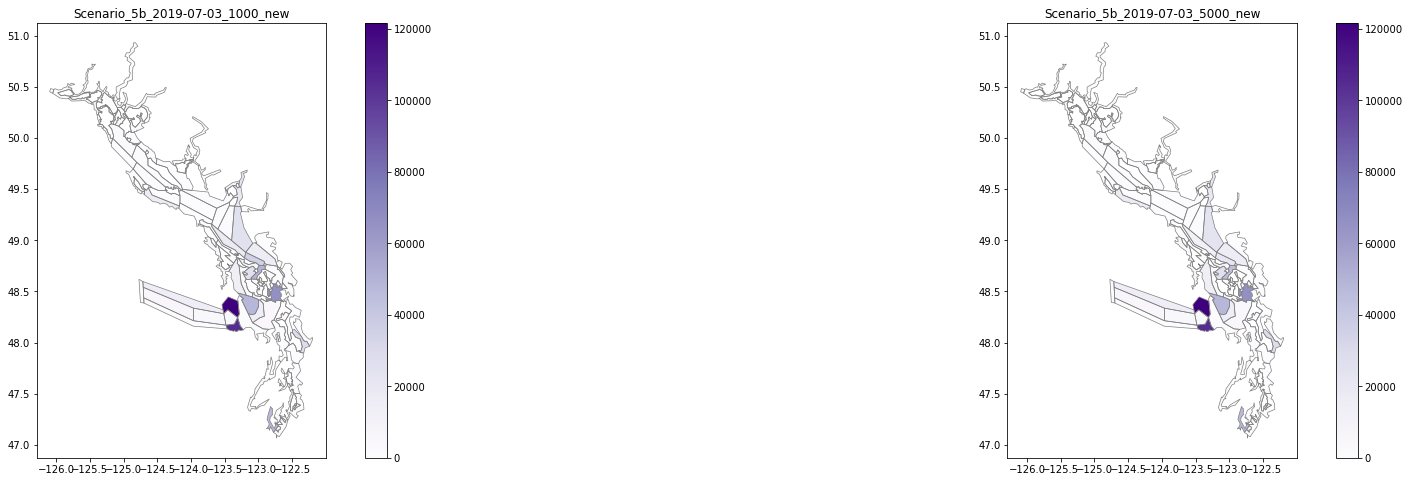

In [106]:
map_aggregate_time('Diatom_N', v_max=None, v_min=None)

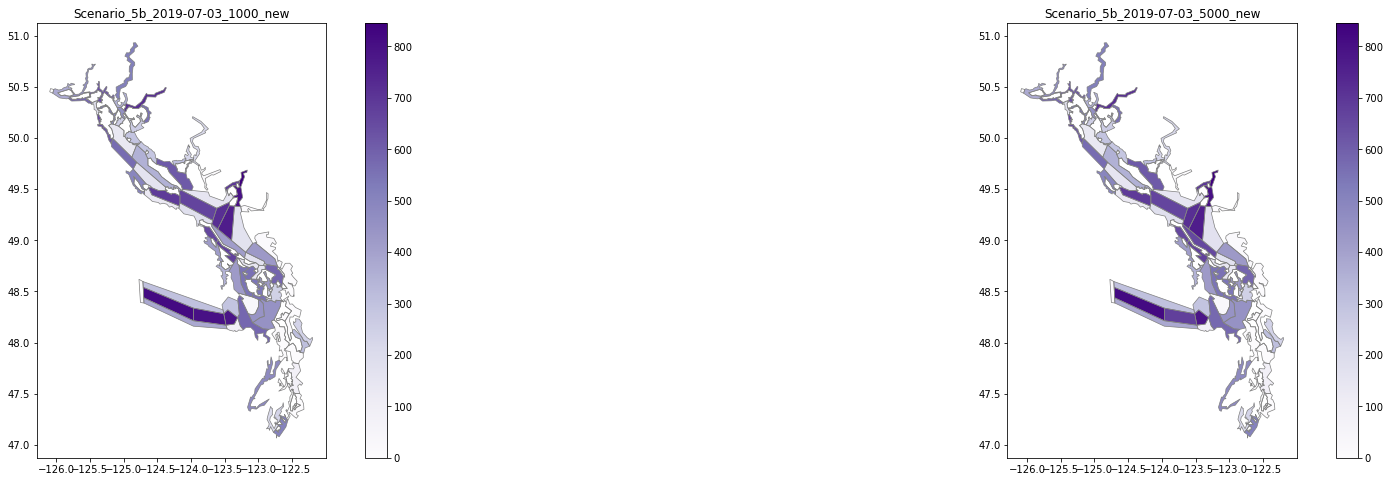

In [107]:
map_aggregate_time('PicoPhytopl_N')

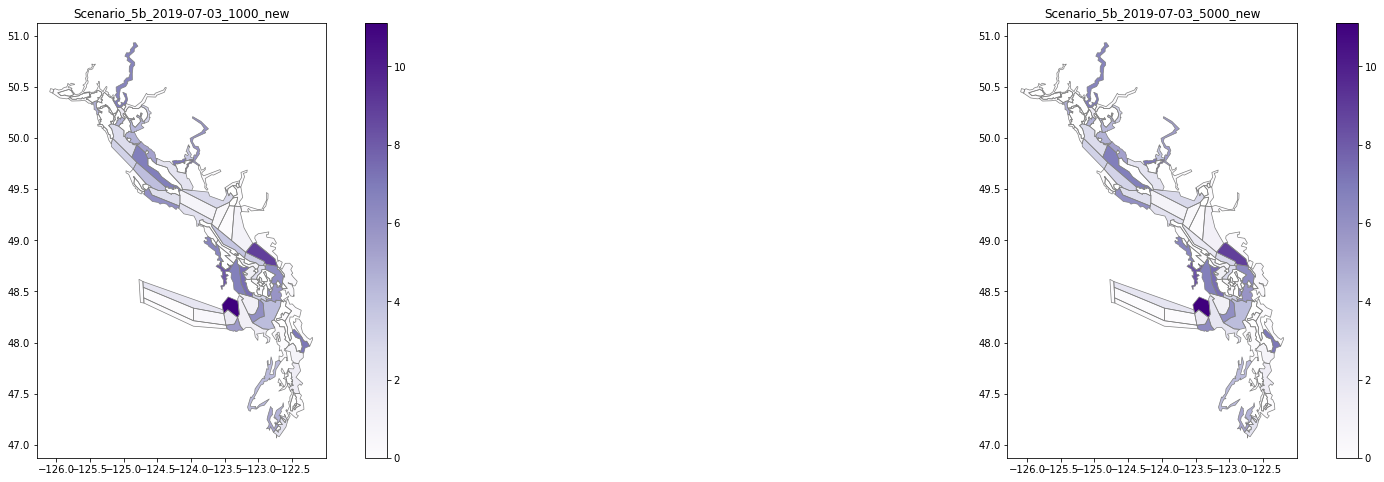

In [108]:
map_aggregate_time('MicroZoo_N') #ZS

In [109]:
def map_pelagic_aggregate_time(variable_name, v_max=100, v_min=-100):

    from mpl_toolkits.axes_grid1 import make_axes_locatable
    
    shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
    map_df = gpd.read_file(shapefile_name)
    map_df = map_df.sort_values(by=['BOX_ID'])
    box_depth = map_df['BOTZ']
    land_boxes = box_depth==0
    land_boxes = map_df.index[land_boxes]
    land_df = map_df.loc[land_boxes]

    _cmap = cm.bwr_r # cm.ocean_r
    
    # map of single variable ratio across the whole simulation

    # Pull variables for all scenarios
    dVar_control = control.variables[variable_name]
    dVar_control = dVar_control.sum(axis=2)
    dVar_control = dVar_control.sum(axis=0)

    fig = plt.figure(figsize=(29, 8), facecolor='white') #figsize=(9, 12)
    gs = plt.GridSpec(1, len(scenario_paths), wspace=0.5, hspace=0.2, height_ratios=[1],)

    position = 0

    for scenario, path in zip(scenario_datasets,scenario_paths):

        dVar_s = scenario.variables[variable_name]
        dVar_s = dVar_s.sum(axis=2)
        dVar_s = dVar_s.sum(axis=0)
        percent_oil = (dVar_s / dVar_control-1)*100 

        # Add scenario data to Atlantis spatial data
        map_df['percent'] = percent_oil
        map_df.loc[land_boxes, 'percent'] = 0

        ax = fig.add_subplot(gs[0, position])
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=-0.5) 
        ax = map_df.plot(column = 'percent', cmap=_cmap, ax=ax, vmin=v_min, vmax=v_max, cax=cax,
            legend=True, #legend_kwds={'label': variable_name + ' % difference from control'},
            )
        ax.set_title(path.parent.stem, fontsize = 12)
        map_df.boundary.plot(ax=ax, color='grey', linewidths=0.7)
        land_df.plot(ax=ax, color='white');
        position = position+1

    return

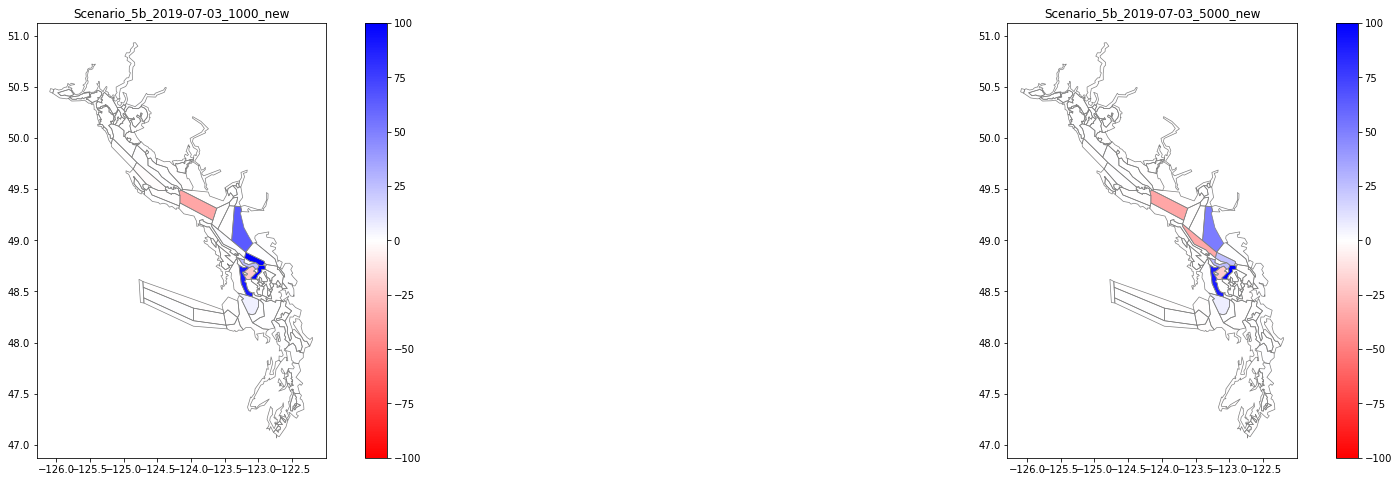

In [110]:
map_pelagic_aggregate_time('Diatom_N')

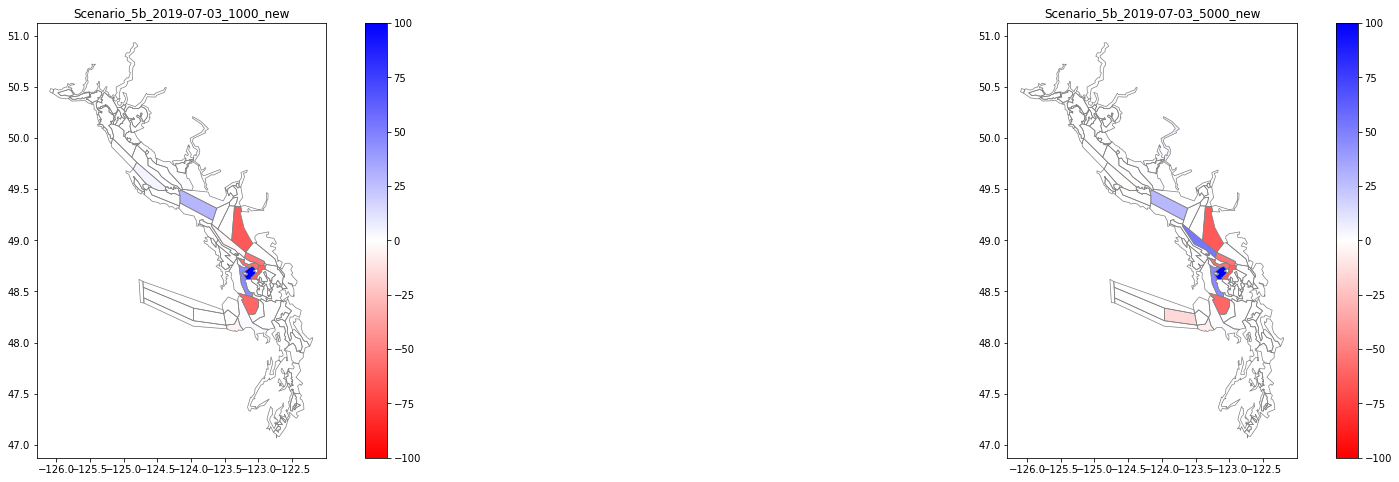

In [111]:
map_pelagic_aggregate_time('PicoPhytopl_N')

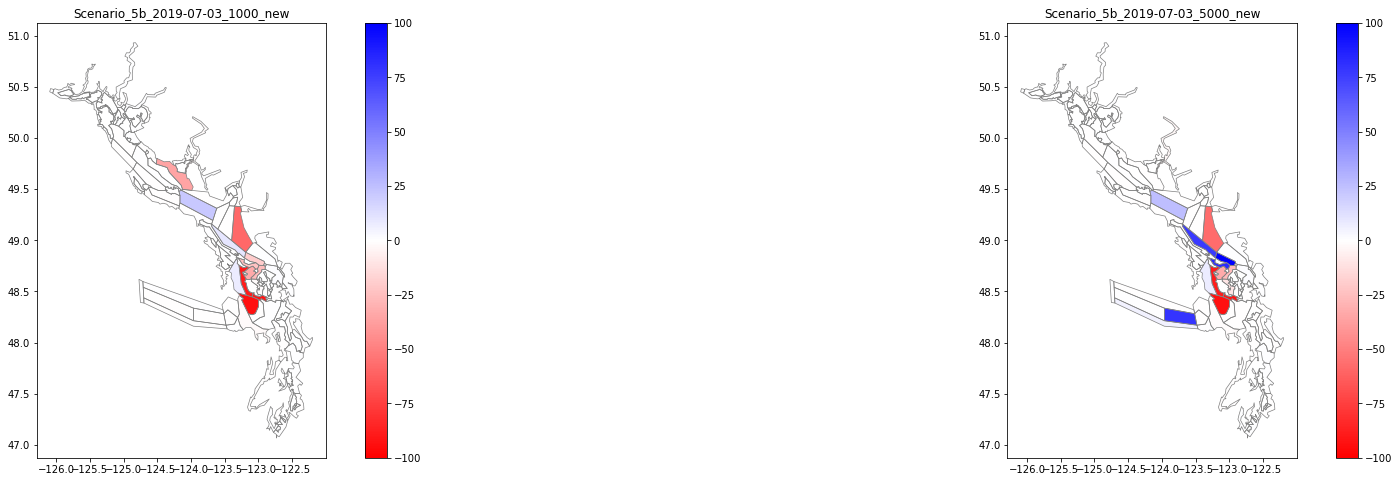

In [112]:
map_pelagic_aggregate_time('Zoo_N') #ZM

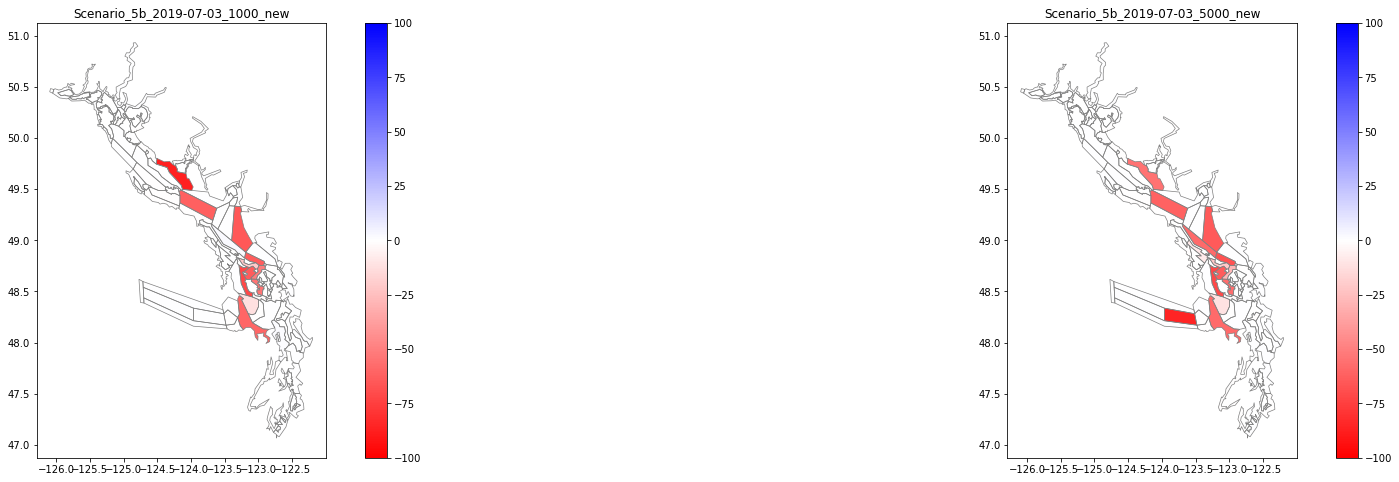

In [113]:
map_pelagic_aggregate_time('Carniv_Zoo_N') #ZL

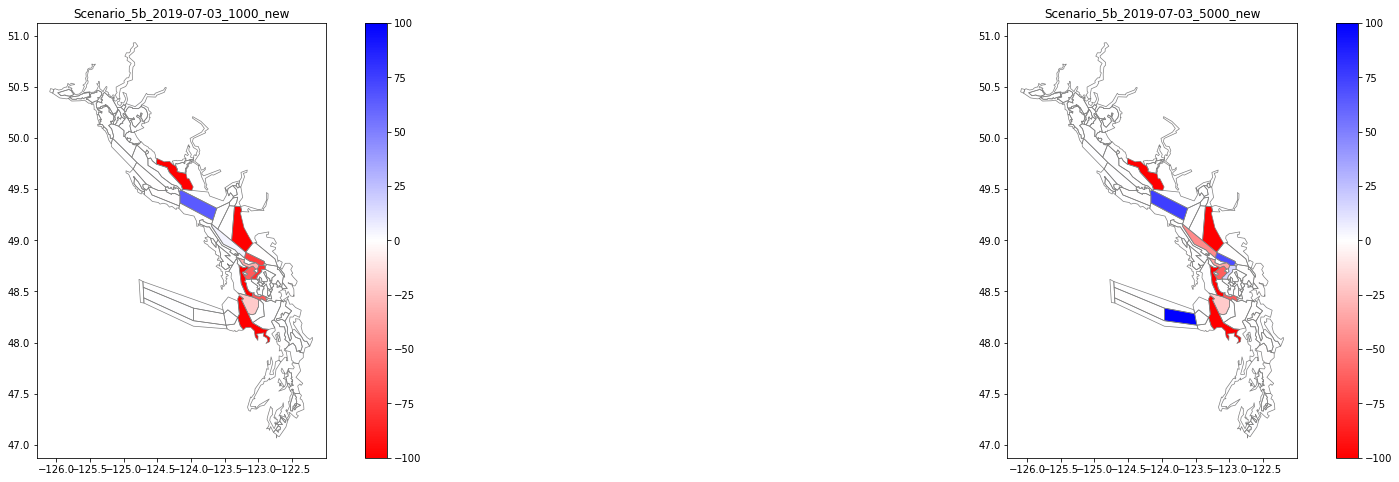

In [114]:
map_pelagic_aggregate_time('Squid_N')

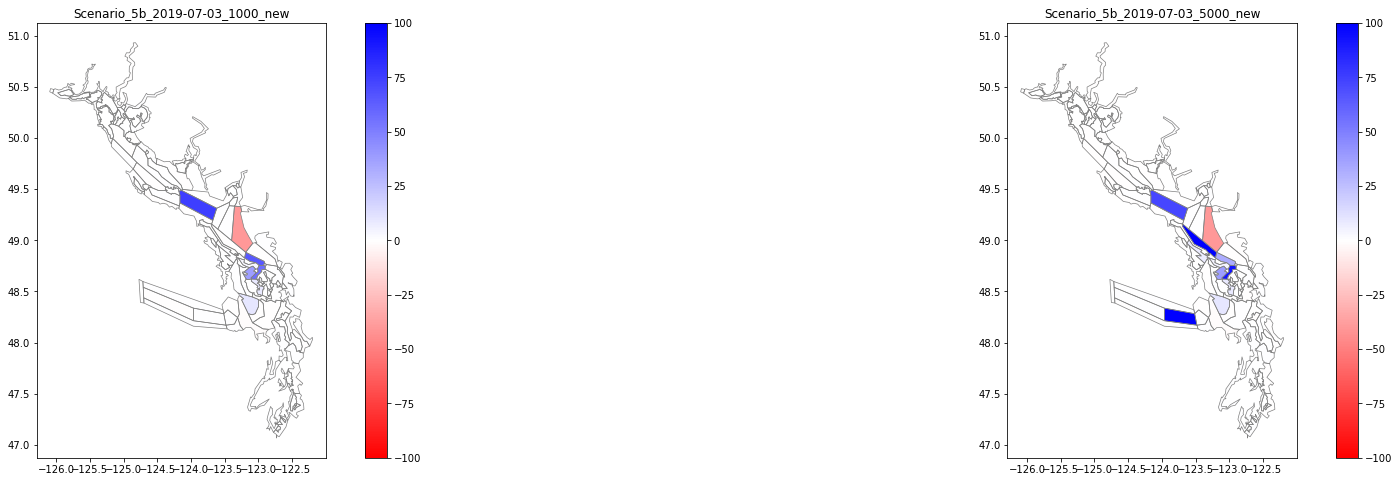

In [115]:
map_pelagic_aggregate_time('Prawn_N')

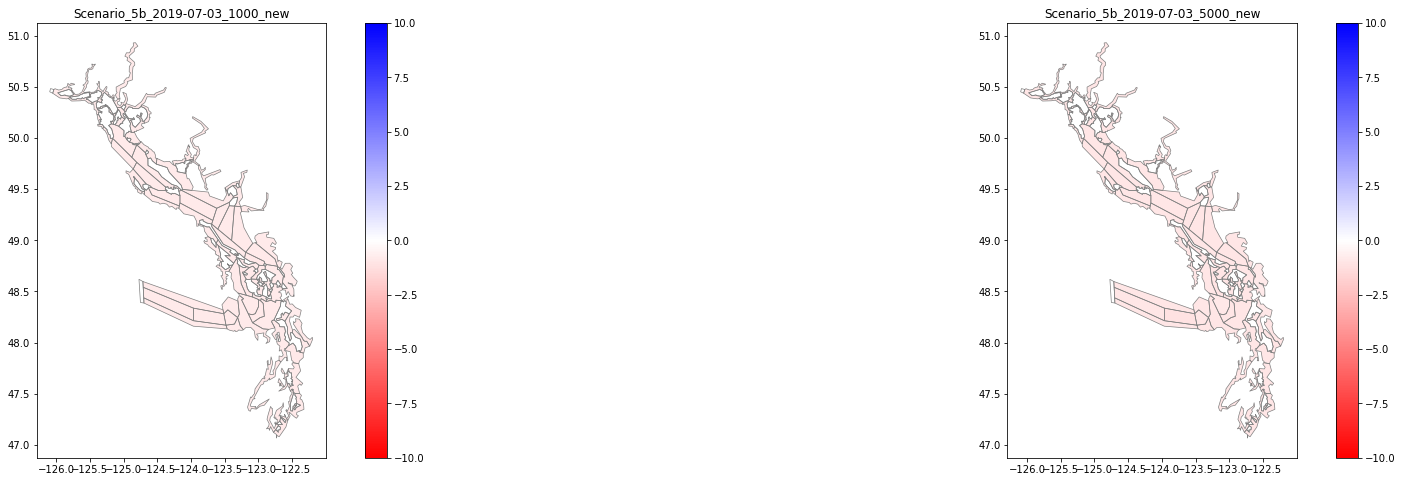

In [116]:
map_pelagic_aggregate_time('Pink_salmon_N', v_max=10, v_min=-10)

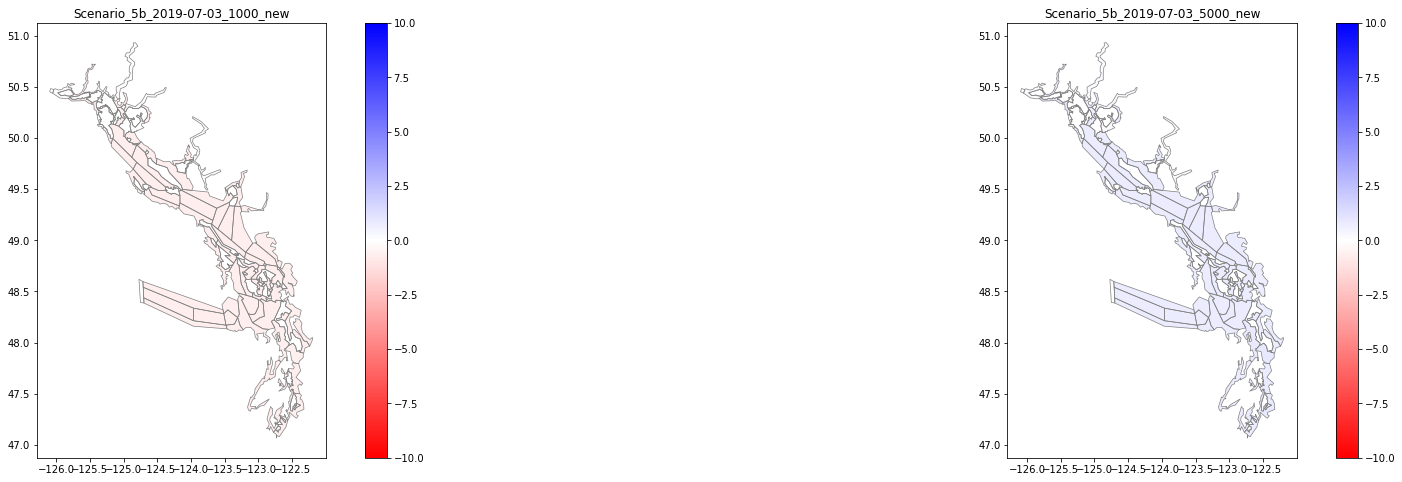

In [117]:
map_pelagic_aggregate_time('Harbor_porpoise_N', v_max=10, v_min=-10)

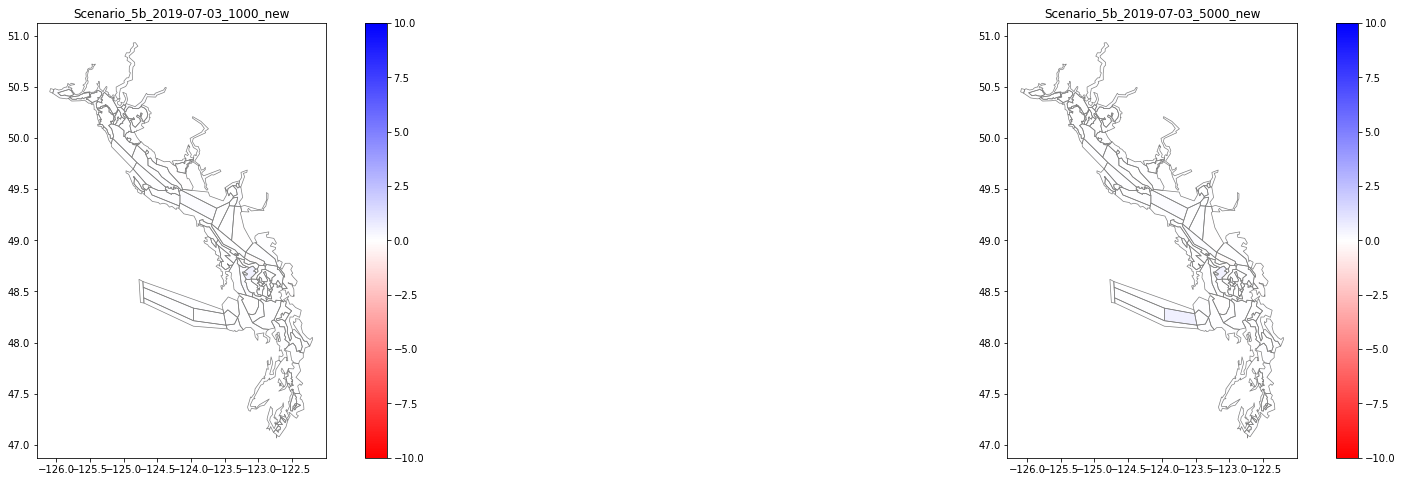

In [118]:
map_pelagic_aggregate_time('Pacific_herring_N', v_max=10, v_min=-10)

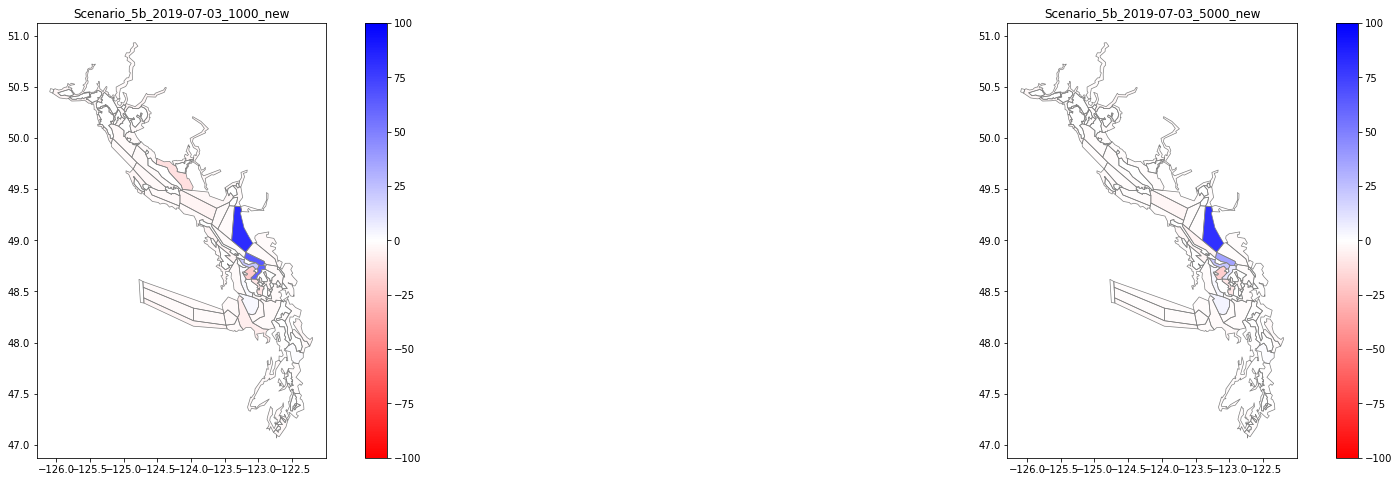

In [119]:
map_pelagic_aggregate_time('Small_pelagic_fish_N')

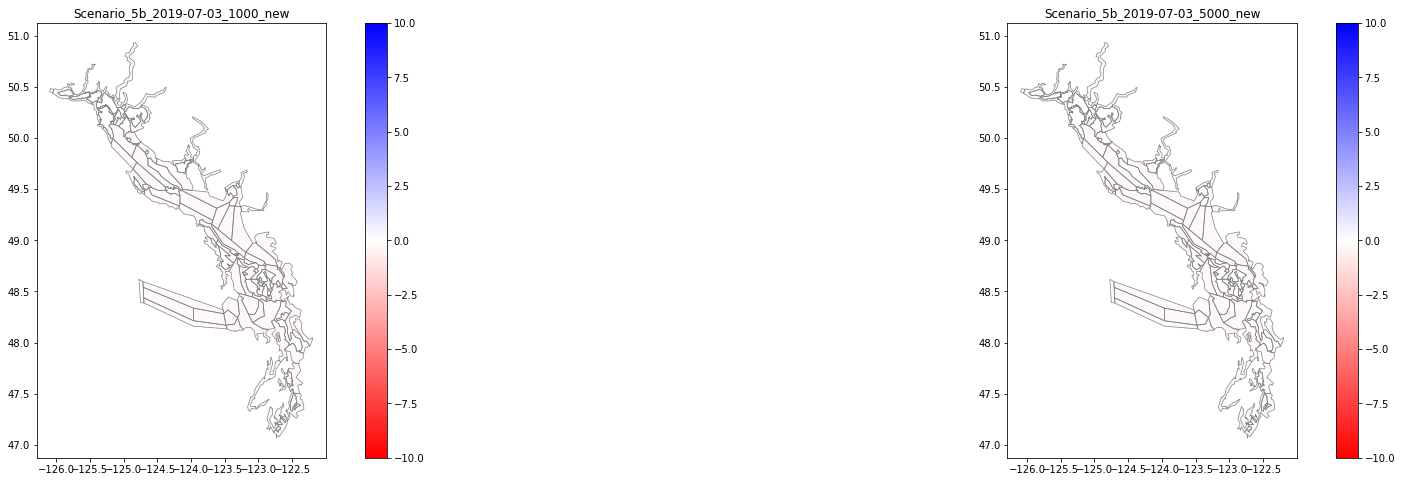

In [120]:
map_pelagic_aggregate_time('Sockeye_salmon_N', v_max=10, v_min=-10)

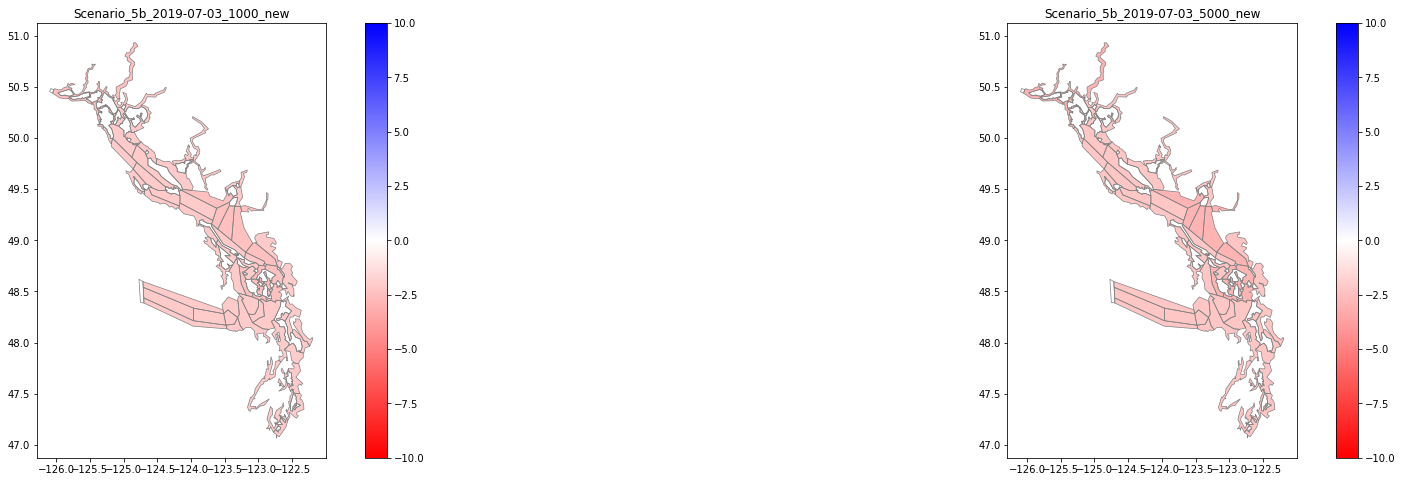

In [121]:
map_pelagic_aggregate_time('Hatchery_Sockeye_salmon_N', v_max=10, v_min=-10)

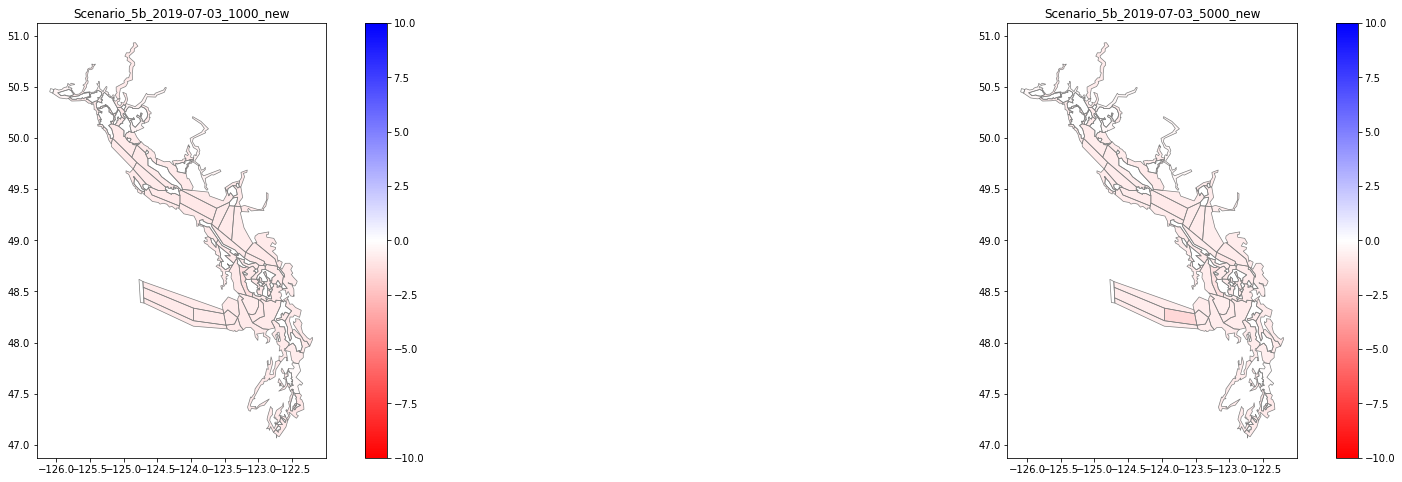

In [122]:
map_pelagic_aggregate_time('Hake_N', v_max=10, v_min=-10)

### oil dispersal

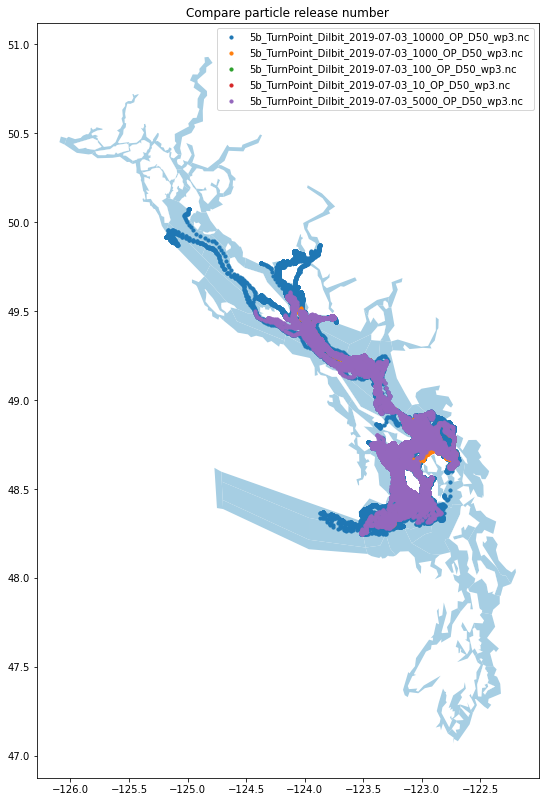

In [126]:
# salish sea atlantis box shapefile.
shapefile_name = "/ocean/rlovindeer/Atlantis/ssam_oceanparcels/SalishSea/SalishSea_July172019_2/SalishSea_July172019.shp"
data_df = gpd.read_file(shapefile_name)
data_df = data_df.sort_values(by=['BOX_ID'])
box_depth = data_df['BOTZ']
land_boxes = box_depth==0
land_boxes = data_df.index[land_boxes]

# Reading in the files generated by Ocean Parcels
scen_path = Path('/ocean/rlovindeer/MOAD/analysis-raisha/notebooks/contaminant-dispersal/')
scens = sorted([p for p in scen_path.glob(this_run + '*_OP_D50_wp3.nc')])

_cmap = cm.Paired
land_df = data_df.loc[land_boxes]

ax = data_df.plot(figsize=(9, 15), column = 'vertmix', cmap=_cmap, 
    vmin=0, vmax = 10,
    legend=False,
    )
land_df.plot(ax=ax, color='white')
oil_names = []

for path in scens:
    onm = str(path).split(sep = '/')
    oil_names.append(onm[-1])

    pfile = xr.open_dataset(str(path), decode_cf=True)

    lon = np.ma.filled(pfile.variables['lon'], np.nan)
    lat = np.ma.filled(pfile.variables['lat'], np.nan)

    ax.scatter(lon, lat, s=10, zorder=20) #s=0.001
ax.set_title('Compare particle release number', fontsize = 12)
ax.legend(oil_names);

In [127]:
scens

[PosixPath('/ocean/rlovindeer/MOAD/analysis-raisha/notebooks/contaminant-dispersal/5b_TurnPoint_Dilbit_2019-07-03_10000_OP_D50_wp3.nc'),
 PosixPath('/ocean/rlovindeer/MOAD/analysis-raisha/notebooks/contaminant-dispersal/5b_TurnPoint_Dilbit_2019-07-03_1000_OP_D50_wp3.nc'),
 PosixPath('/ocean/rlovindeer/MOAD/analysis-raisha/notebooks/contaminant-dispersal/5b_TurnPoint_Dilbit_2019-07-03_100_OP_D50_wp3.nc'),
 PosixPath('/ocean/rlovindeer/MOAD/analysis-raisha/notebooks/contaminant-dispersal/5b_TurnPoint_Dilbit_2019-07-03_10_OP_D50_wp3.nc'),
 PosixPath('/ocean/rlovindeer/MOAD/analysis-raisha/notebooks/contaminant-dispersal/5b_TurnPoint_Dilbit_2019-07-03_5000_OP_D50_wp3.nc')]